In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint ,  solve_ivp

In [73]:
def opto_non_linear(t,z,g_z0,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,a_0,a_p1,a_m1,a_0_d,a_p1_d,a_m1_d=z
    n_0=a_0_d*a_0
    sigma_m=1j*(a_0_d*(a_p1-a_m1)-a_0*(a_p1_d-a_m1_d))
    N_eff=g_z1*(a_p1*a_p1_d+a_m1*a_m1_d)+g_z0*n_0
    q_y_dot     =p_y
    p_y_dot     =-q_y-g_y*sigma_m*N0
    
    q_z_dot     =p_z
    p_z_dot     =-q_z-2*N_eff*N0

    a_0_dot=-1j*(del_omega+g_z0*q_z)*a_0+g_y*q_y*(a_p1-a_m1)/2
    a_p1_dot=-1j*g_z1*q_z*a_p1-g_y*q_y*a_0/2
    a_m1_dot=-1j*g_z1*q_z*a_m1+g_y*q_y*a_0/2
    
    a_0_d_dot=1j*(del_omega+g_z0*q_z)*a_0_d+g_y*q_y*(a_p1_d-a_m1_d)/2
    a_p1_d_dot=1j*g_z1*q_z*a_p1_d-g_y*q_y*a_0_d/2
    a_m1_d_dot=1j*g_z1*q_z*a_m1_d+g_y*q_y*a_0_d/2

    
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,a_0_dot,a_p1_dot,a_m1_dot,a_0_d_dot,a_p1_d_dot,a_m1_d_dot]
    return x_list

# def opto_non_linear_2(t,z,g_z0,g_z1,g_y,del_omega,N0):
#     ##less accurate
#     q,p,a_0,a_p1,a_m1=z
    
#     a_0_d=np.conj(a_0)
#     a_p1_d=np.conj(a_0)
#     a_m1_d=np.conj(a_0)
    
#     n_0=a_0_d*a_0
#     sigma_m=1j*(a_0_d*(a_p1-a_m1)-a_0*(a_p1_d-a_m1_d))
#     q_dot     =-p
#     p_dot     =q+g_y*sigma_m*N0
    
#     a_0_dot   = 1j*a_0*(-del_omega + ((g_z0-g_z1)**2*(2*n_0*N0+1)+2*g_z1*(g_z0-g_z1)*(N0+n_0*N0+1)) )  + g_y*q*(a_p1-a_m1)/2
#     a_p1_dot  = 1j*a_p1*(2*g_z1*(g_z0-g_z1)*n_0*N0 )    - g_y*q*a_0/2
#     a_m1_dot  = 1j*a_m1*(2*g_z1*(g_z0-g_z1)*n_0*N0 )    + g_y*q*a_0/2
    
    
#     x_list=[q_dot,p_dot,a_0_dot,a_p1_dot,a_m1_dot]
#     return x_list


def opto_linear(t,z,g_z0,g_z1,g_y, del_omega,N0):
    q,p,a_0,a_p1,a_m1,a_0_d,a_p1_d,a_m1_d=z
    delta=del_omega-2*g_z1*(g_z0-g_z1)*N0-(g_z0**2-g_z1**2)
    sigma_m=1j*(a_p1-a_m1-a_p1_d-a_m1_d)
    q_dot     =-p
    p_dot     =q+g_y*sigma_m*N0
    
    a_0_dot   = 0
    a_p1_dot  = 1j*a_p1*delta    - g_y*q/2
    a_m1_dot  = 1j*a_m1*delta   + g_y*q/2
    
    a_0_d_dot =  0
    a_p1_d_dot= -1j*a_p1_d*delta- g_y*q/2
    a_m1_d_dot= -1j*a_m1_d*delta + g_y*q/2
    

    x_list=[q_dot,p_dot,a_0_dot,a_p1_dot,a_m1_dot,a_0_d_dot,a_p1_d_dot,a_m1_d_dot]
    return x_list

    
def evolve(x_0,a,tf,param_list,N_step=300,linear=False):
    q_z_0,p_z_0,q_y_0,p_y_0=x_0
    g_z0,g_z1,g_y, del_omega, N0=param_list
    z0=np.array([q_z_0,p_z_0,q_y_0,p_y_0,a[0],a[1],a[-1],a[0].conj(),a[1].conj(),a[-1].conj()])
#     z0=np.array([q_0,p_0,a[0],a[1],a[-1],a[0].conj(),a[1].conj(),a[-1].conj()])
    t = np.linspace(0,tf,N_step)
    func= opto_linear if linear else opto_non_linear
    xx=solve_ivp(func, [0,tf],z0,args=param_list,dense_output=True,rtol = 1e-8, atol = 1e-8, t_eval=t)
    zz=xx.sol(t)
    sol=[]
    sol.extend( (np.real(zz[0]),np.real(zz[1]),np.real(zz[2]),np.real(zz[3])) )
#     E_mech=(p**2+q**2)/4
    n_0=zz[4]*zz[7]
    n_p1=zz[5]*zz[8]
    n_m1=zz[6]*zz[9]
    #E_opt=omega_1*(n_p1+n_m1)+omega_0*n_0
    N=n_0+n_p1+n_m1
    sigma_m=1j*(zz[7]*(zz[5]-zz[6])-zz[4]*(zz[8]-zz[9]))
    sol.extend( (np.abs(1-n_0),np.abs(n_p1),np.abs(N),np.abs(sigma_m)) )
    return sol,t


def lyapunov(param_list):
    g_z0,g_z1,g_y,del_omega,N0=param_list
    E=[]
    delta=del_omega-2*N0*g_z1*(g_z0-g_z1)+g_z0**2-g_z1**2
    lam_p1=(((1+delta**2)+((1-delta**2)**2-8*delta*g_y**2*N0)**0.5)/2)**0.5
    lam_p2=-lam_p1
    lam_m1=(((1+delta**2)-((1-delta**2)**2-8*delta*g_y**2*N0)**0.5)/2)**0.5
    lam_m2=-lam_m1
    E.append(lam_p1)
    E.append(lam_p2)
    E.append(lam_m1)
    E.append(lam_m2)
    return E

def Pc(param_list):
    g_z0,g_z1,g_y,del_omega,N0=param_list
    delta=del_omega-2*N0*g_z1*(g_z0-g_z1)+g_z0**2-g_z1**2
    #Pc=g_y**2*N_0/delta
    Pc=(8*delta*g_y**2*N0)/(1-delta**2)**2
    return Pc

def freq(param_list):
    g_z0,g_z1,g_y,del_omega,N0=param_list
    delta=del_omega+2*N0*g_z1*(g_z0-g_z1)+(g_z0**2-g_z1**2)
    w_m=1-g_y**2*N0/delta
    w_p=delta+g_y**2*N0/delta**2
    return w_m,w_p

In [9]:
g_y=1.24e6   ##Hz
omega_0=4.45e15 ##Hz
del_omega=1e8
omega_1=omega_0-del_omega ##Hz
ohm=1e6         ##Hz
g_z0=0
g_z1=(20*ohm)**0.5
delta_0=100*ohm
N0=1e1

g_y/=ohm
g_z1/=ohm
g_z0/=ohm
omega_1/=ohm
omega_0/=ohm
del_omega/=ohm

label_list=["$Q$","$P$","$1-n_0$","$n_1$","$n_{-1}$","$\sigma_-$","E_mech"]


$\lambda_{\pm}^2=\frac{(1+\Delta^2)\pm \sqrt{(1-\Delta^2)^2-8\Delta g_y^2 N_0}}{2}$
$\newline$
$\Delta=\delta_\omega-2N_0 g_1^z(g_0^z-g_1^z)+(g_0^z)^2-(g_1^z)^2$


In [50]:
del_omega

100.0

In [54]:
x_0=[0.+0j,0.+0j,1.612*1e-1+0j,0.+0j]
q_z_0,p_z_0,q_y_0,p_y_0=x_0
print(q_z_0,p_z_0,q_y_0,p_y_0)

0j 0j (0.1612+0j) 0j


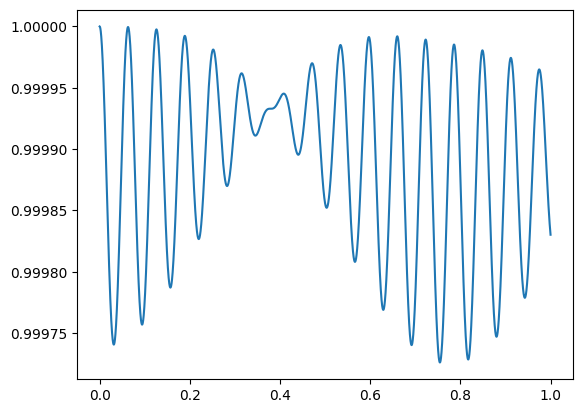

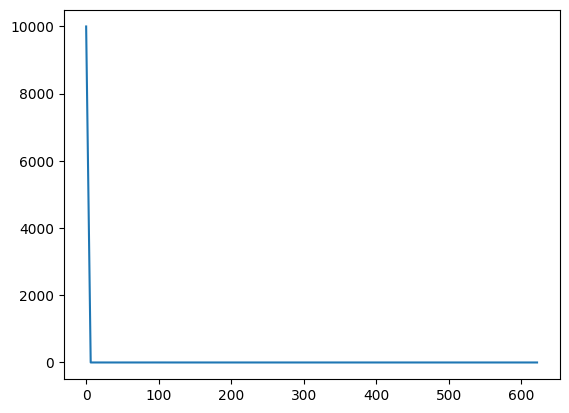

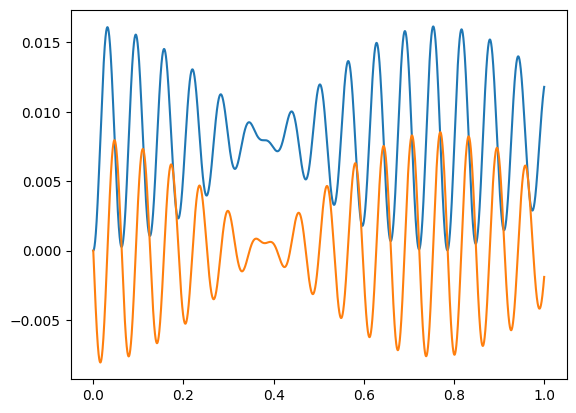

In [27]:
# label_list=["$|a_1|$","$|a_{-1}|$","$arg(a_1)$","$arg(a_{-1})$",]

tf=1e0
N_step=10000
g_y=1e1
N0=8
x_0=[0.+0j,0.+0j,1.612*1e-1+0j,0.+0j]
a_0=np.array([1+0j,0+0j,0+0j])
param_list=[g_z0,g_z1,g_y,del_omega,N0] 
#########
q_z_0,p_z_0,q_y_0,p_y_0=x_0
z0=np.array([q_z_0,p_z_0,q_y_0,p_y_0,a_0[0],a_0[1],a_0[-1],a_0[0].conj(),a_0[1].conj(),a_0[-1].conj()])
t = np.linspace(0,tf,N_step)
xx=solve_ivp(opto_non_linear, [0,tf],z0,args=param_list,dense_output=True,rtol = 1e-8, atol = 1e-8, t_eval=t)
zz=xx.sol(t)
sol=[]
# sol.extend( (np.abs(zz[]),np.abs(n_p1),np.abs(n_m1),np.abs(sigma_m)) )
# sol.extend( ( np.abs(zz[5]*zz[8]-zz[6]*zz[9]),np.abs(zz[5]),np.abs(zz[5]-zz[6]),np.angle(zz[5]-zz[6]) ) )
##########
# l=len(sol)
# fig, axs = plt.subplots(l//2, 2,figsize=(20,4*l))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
# for i in range(l):
#     axs[i//2,i%2].plot(t,sol[i],label="P_c"+'='+"{:.1e}".format(Pc(param_list)))
# #     axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
#     axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
#     axs[i//2,i%2].legend(fontsize=12)

# plt.show() 
#########
# plt.plot(t,1-np.abs(zz[4]*zz[7]))
# plt.show()
# plt.plot(t,np.angle(zz[5]))
# plt.show()
# plt.plot(t,np.abs(zz[5]))
# plt.show()
zg=zz[4]*np.exp(1j*del_omega*t)
plt.plot(t,np.real(zg))
plt.show()
# plt.plot(np.real(zz[4]),np.imag(zz[4]))
# plt.axis("equal")
# plt.xlim([0.9,1.1])
# plt.ylim([-0.1,0.1])
# plt.show()
# plt.plot(t[:],np.real(zz[4])[:],t[:],np.imag(zz[4])[:])
# plt.show()
# z_f=np.abs(np.fft.fft(1-np.abs(zz[4]*zz[7])))
# omega=2*np.pi*np.arange(N_step)/tf
# plt.plot(omega[:100],z_f[:100])
# plt.show()
# z_f=np.abs(np.fft.fft(np.abs(zz[5])))
z_f=np.abs(np.fft.fft(np.real(zz[4]*np.exp(1j*del_omega*t))))
plt.plot(omega[:100],z_f[:100])
plt.show()
# z_f=np.abs(np.fft.fft(zz[4].real))
# omega=2*np.pi*np.arange(N_step)/tf
# plt.plot(omega,z_f/2)
# plt.show()
# z_f=np.angle(np.fft.fft(zz[4].imag))
# omega=2*np.pi*np.arange(N_step)/tf
# plt.plot(omega,z_f)
# plt.show()
# z_f=np.angle(np.fft.fft(zz[4]))
# omega=2*np.pi*np.arange(N_step)/tf
# plt.plot(omega,z_f/2)
# plt.show()
plt.plot(t,np.imag(zz[5]),t,np.real(zz[5]))
plt.show()



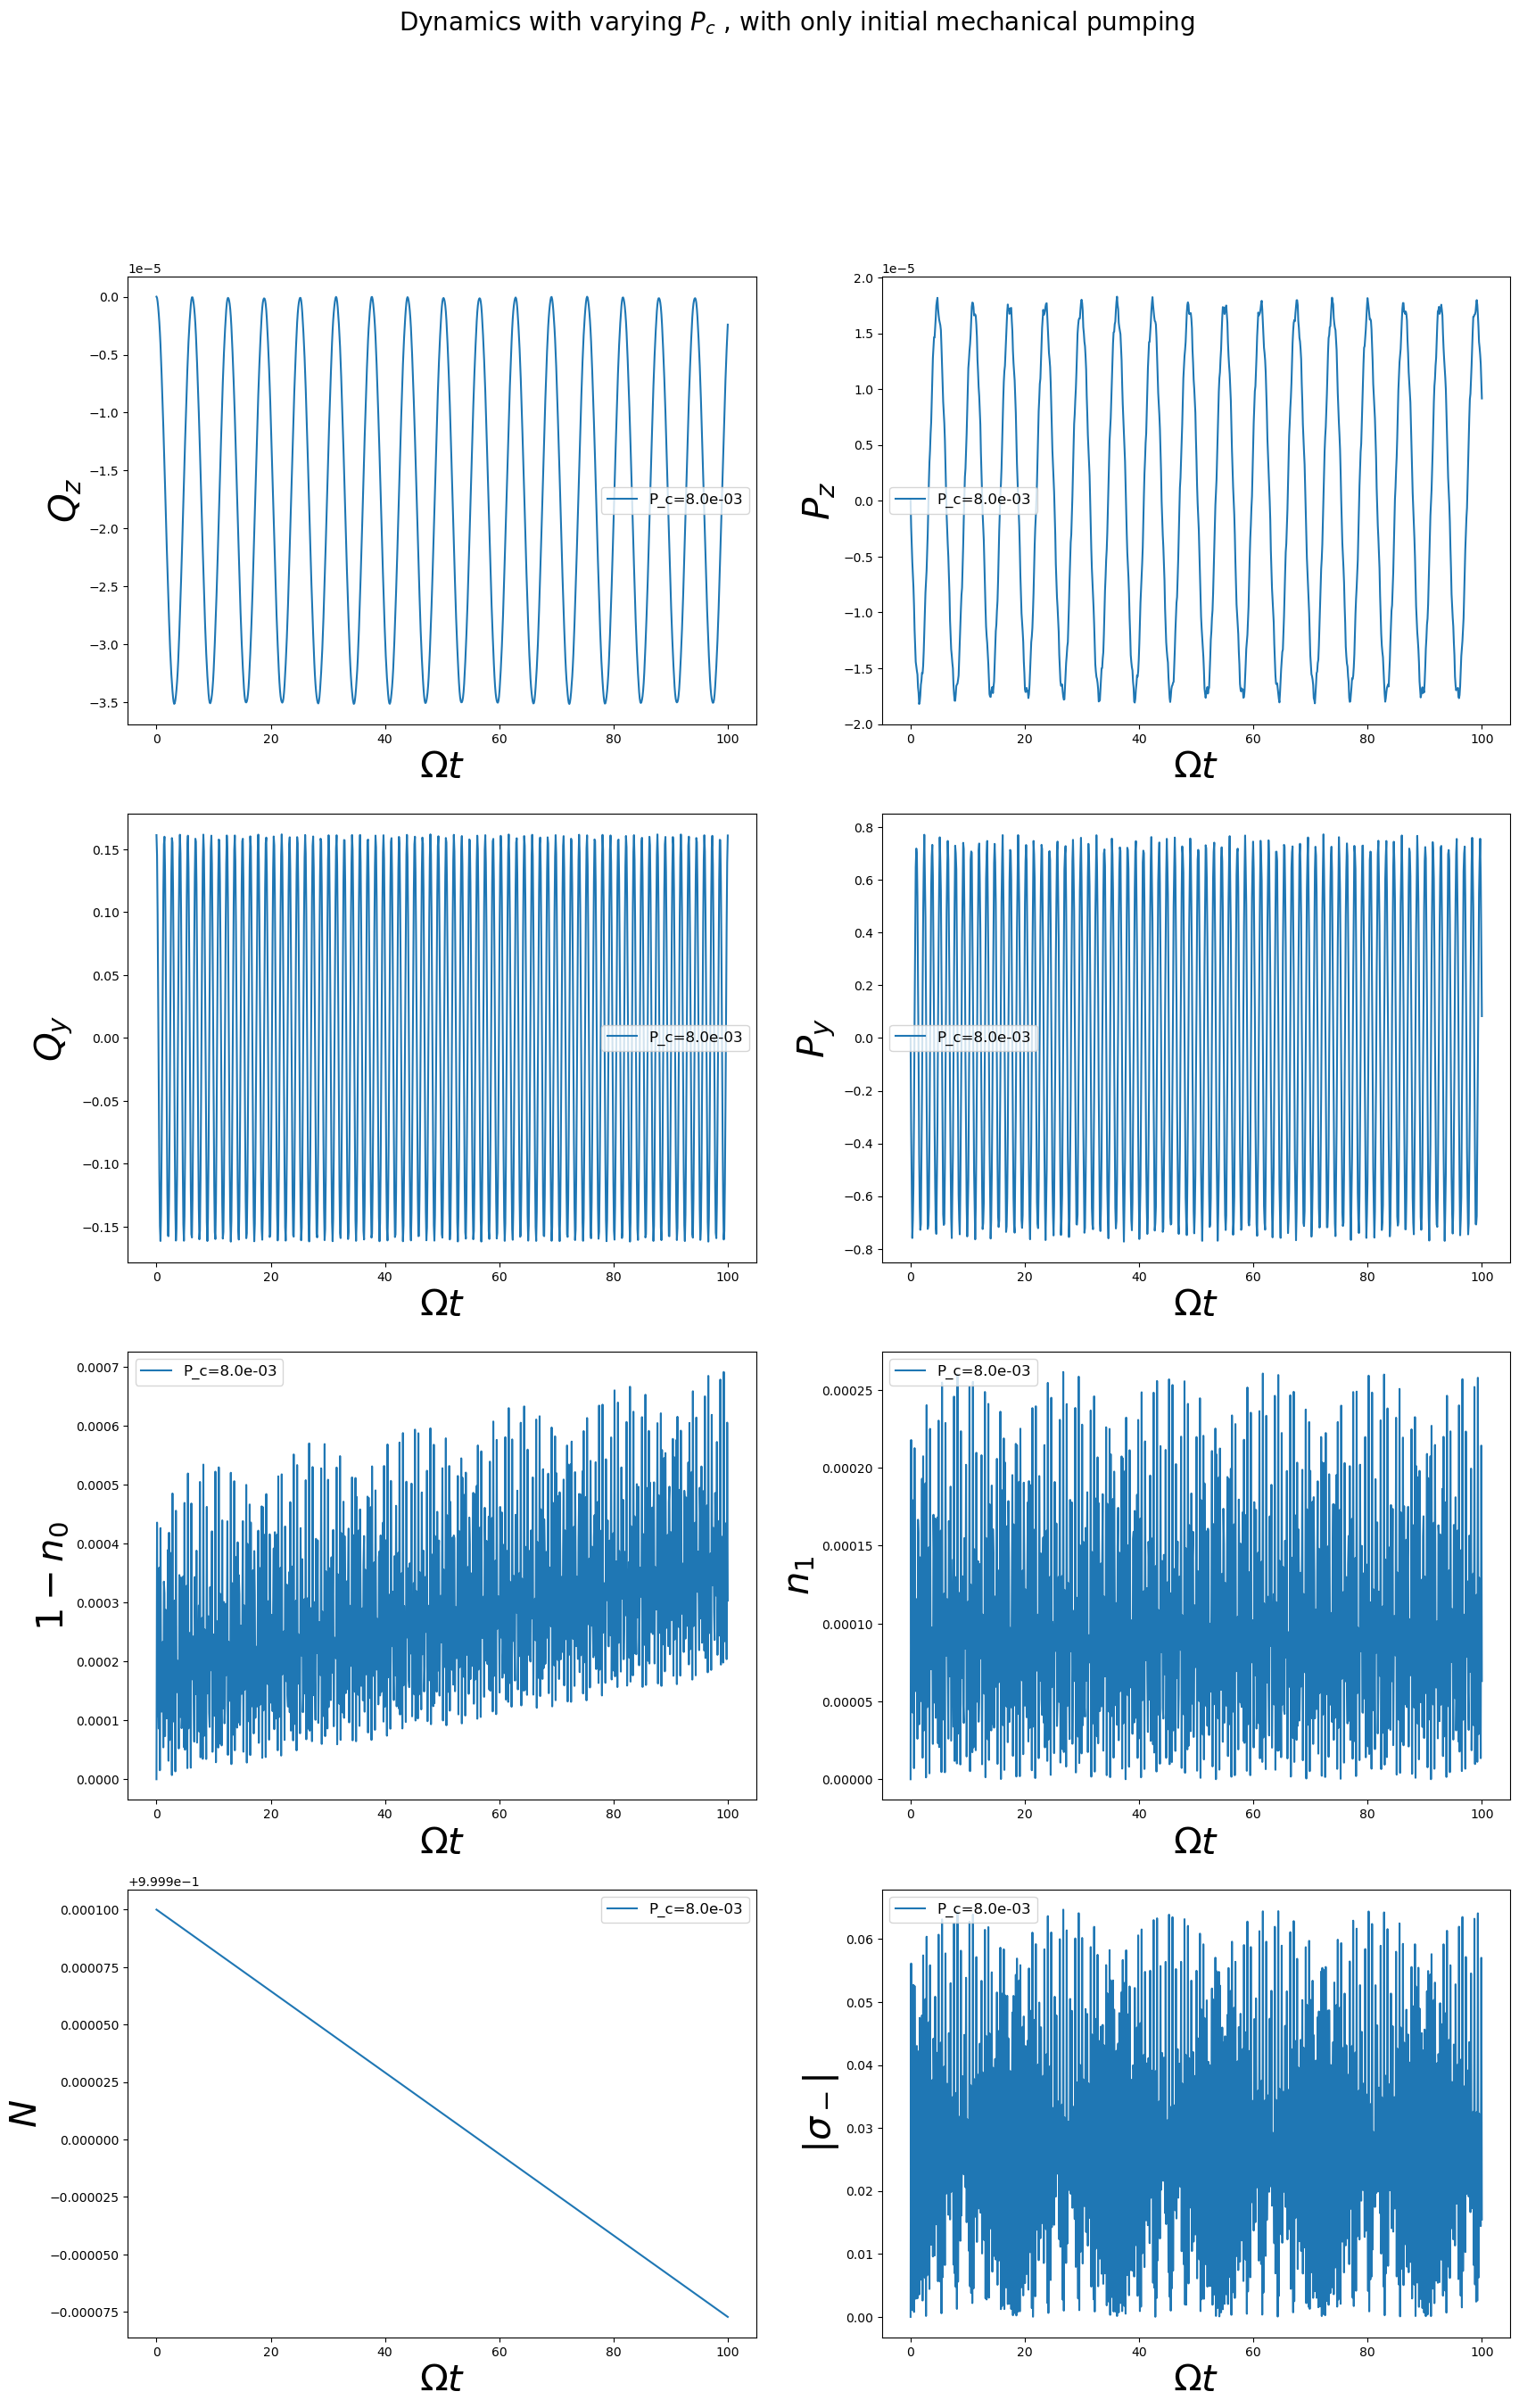

In [74]:
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$1-n_0$","$n_1$","$N$","$|\sigma_-|$"]

tf=1e2
N_step=1000
g_y=1e1
fig, axs = plt.subplots(4, 2,figsize=(20,30))
fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
# N0_list=np.linspace(8,9,1)
N0_list=[10]
x_0=[0.+0j,0.+0j,1.612*1e-1+0j,0.+0j]
psi_0=np.array([1+0j,0+0j,0+0j])

for N0 in (N0_list):
    param_list=[g_z0,g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=evolve(x_0,psi_0,tf,param_list,N_step,linear=False)
    for i in range(8):
        axs[i//2,i%2].plot(t,zz[i],label="P_c"+'='+"{:.1e}".format(Pc(param_list)))
for i in range(8):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
    axs[i//2,i%2].legend(fontsize=12)

plt.show() 

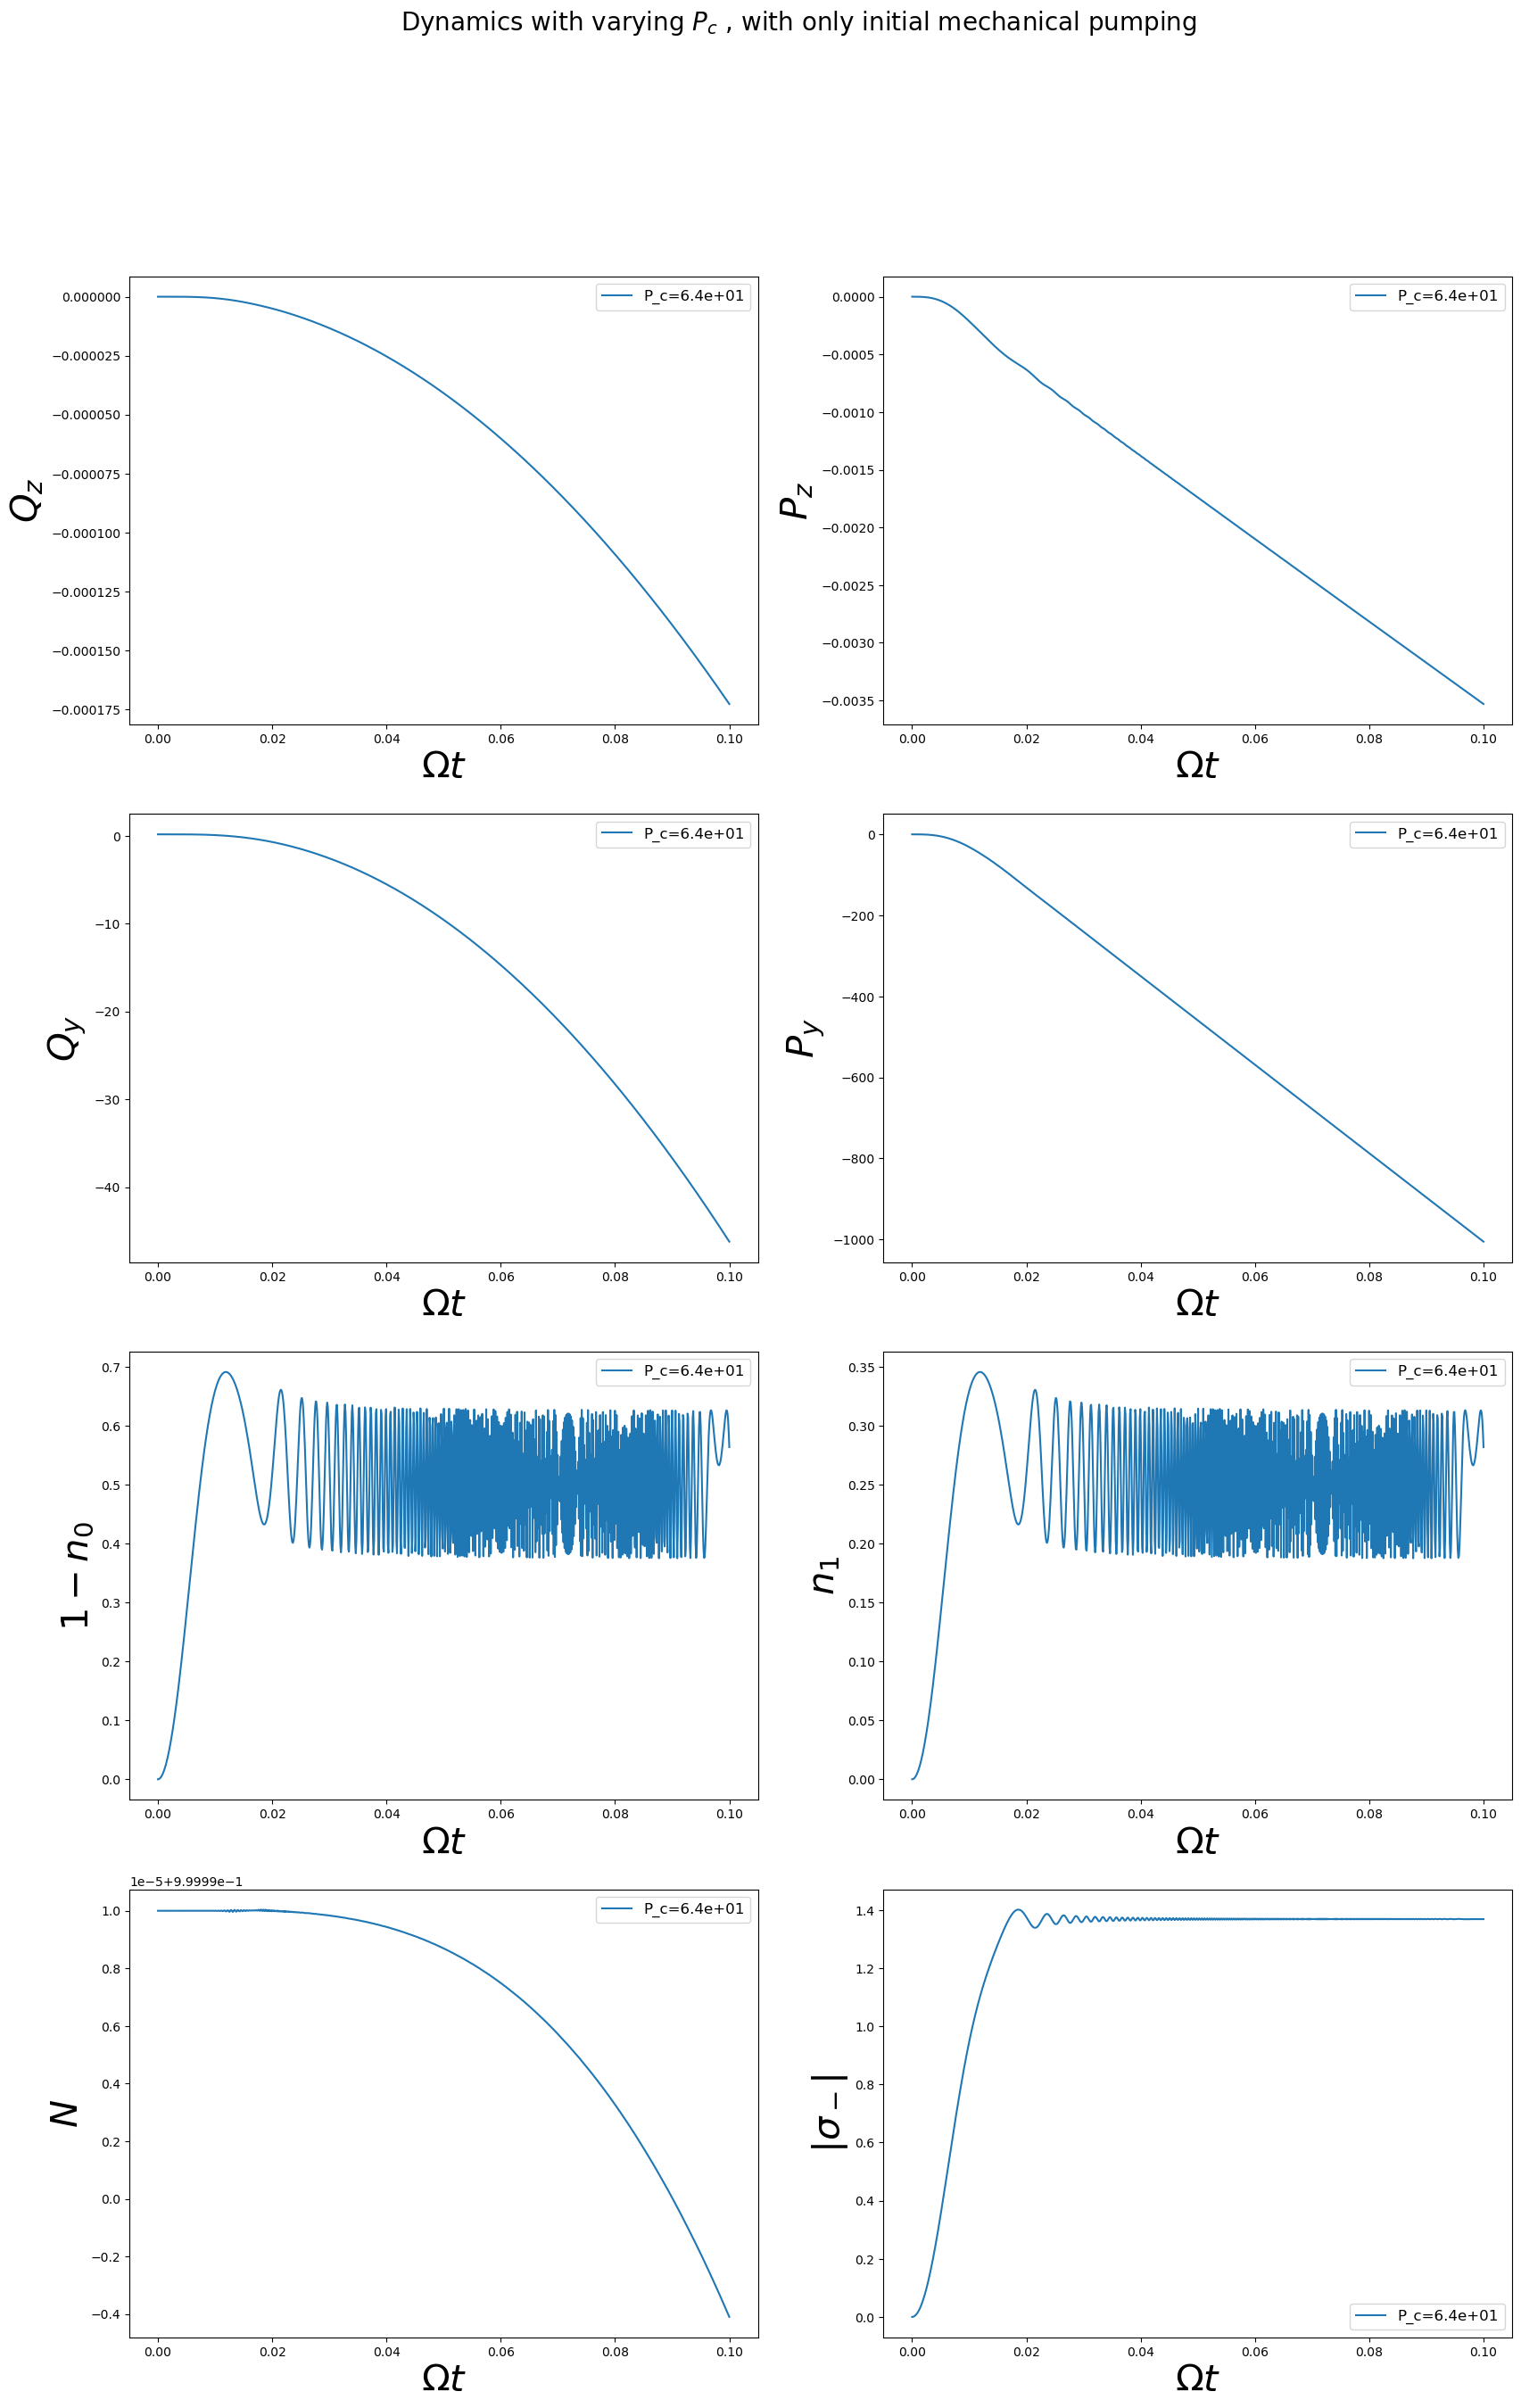

In [75]:
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$1-n_0$","$n_1$","$N$","$|\sigma_-|$"]

tf=1e-1
N_step=1000
g_y=1e3
fig, axs = plt.subplots(4, 2,figsize=(20,30))
fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
N0_list=np.linspace(8,9,1)
x_0=[0.+0j,0.+0j,1.612*1e-1+0j,0.+0j]
psi_0=np.array([1+0j,0+0j,0+0j])

for N0 in (N0_list):
    param_list=[g_z0,g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=evolve(x_0,psi_0,tf,param_list,N_step,linear=False)
    for i in range(8):
        axs[i//2,i%2].plot(t,zz[i],label="P_c"+'='+"{:.1e}".format(Pc(param_list)))
for i in range(8):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
    axs[i//2,i%2].legend(fontsize=12)

plt.show() 

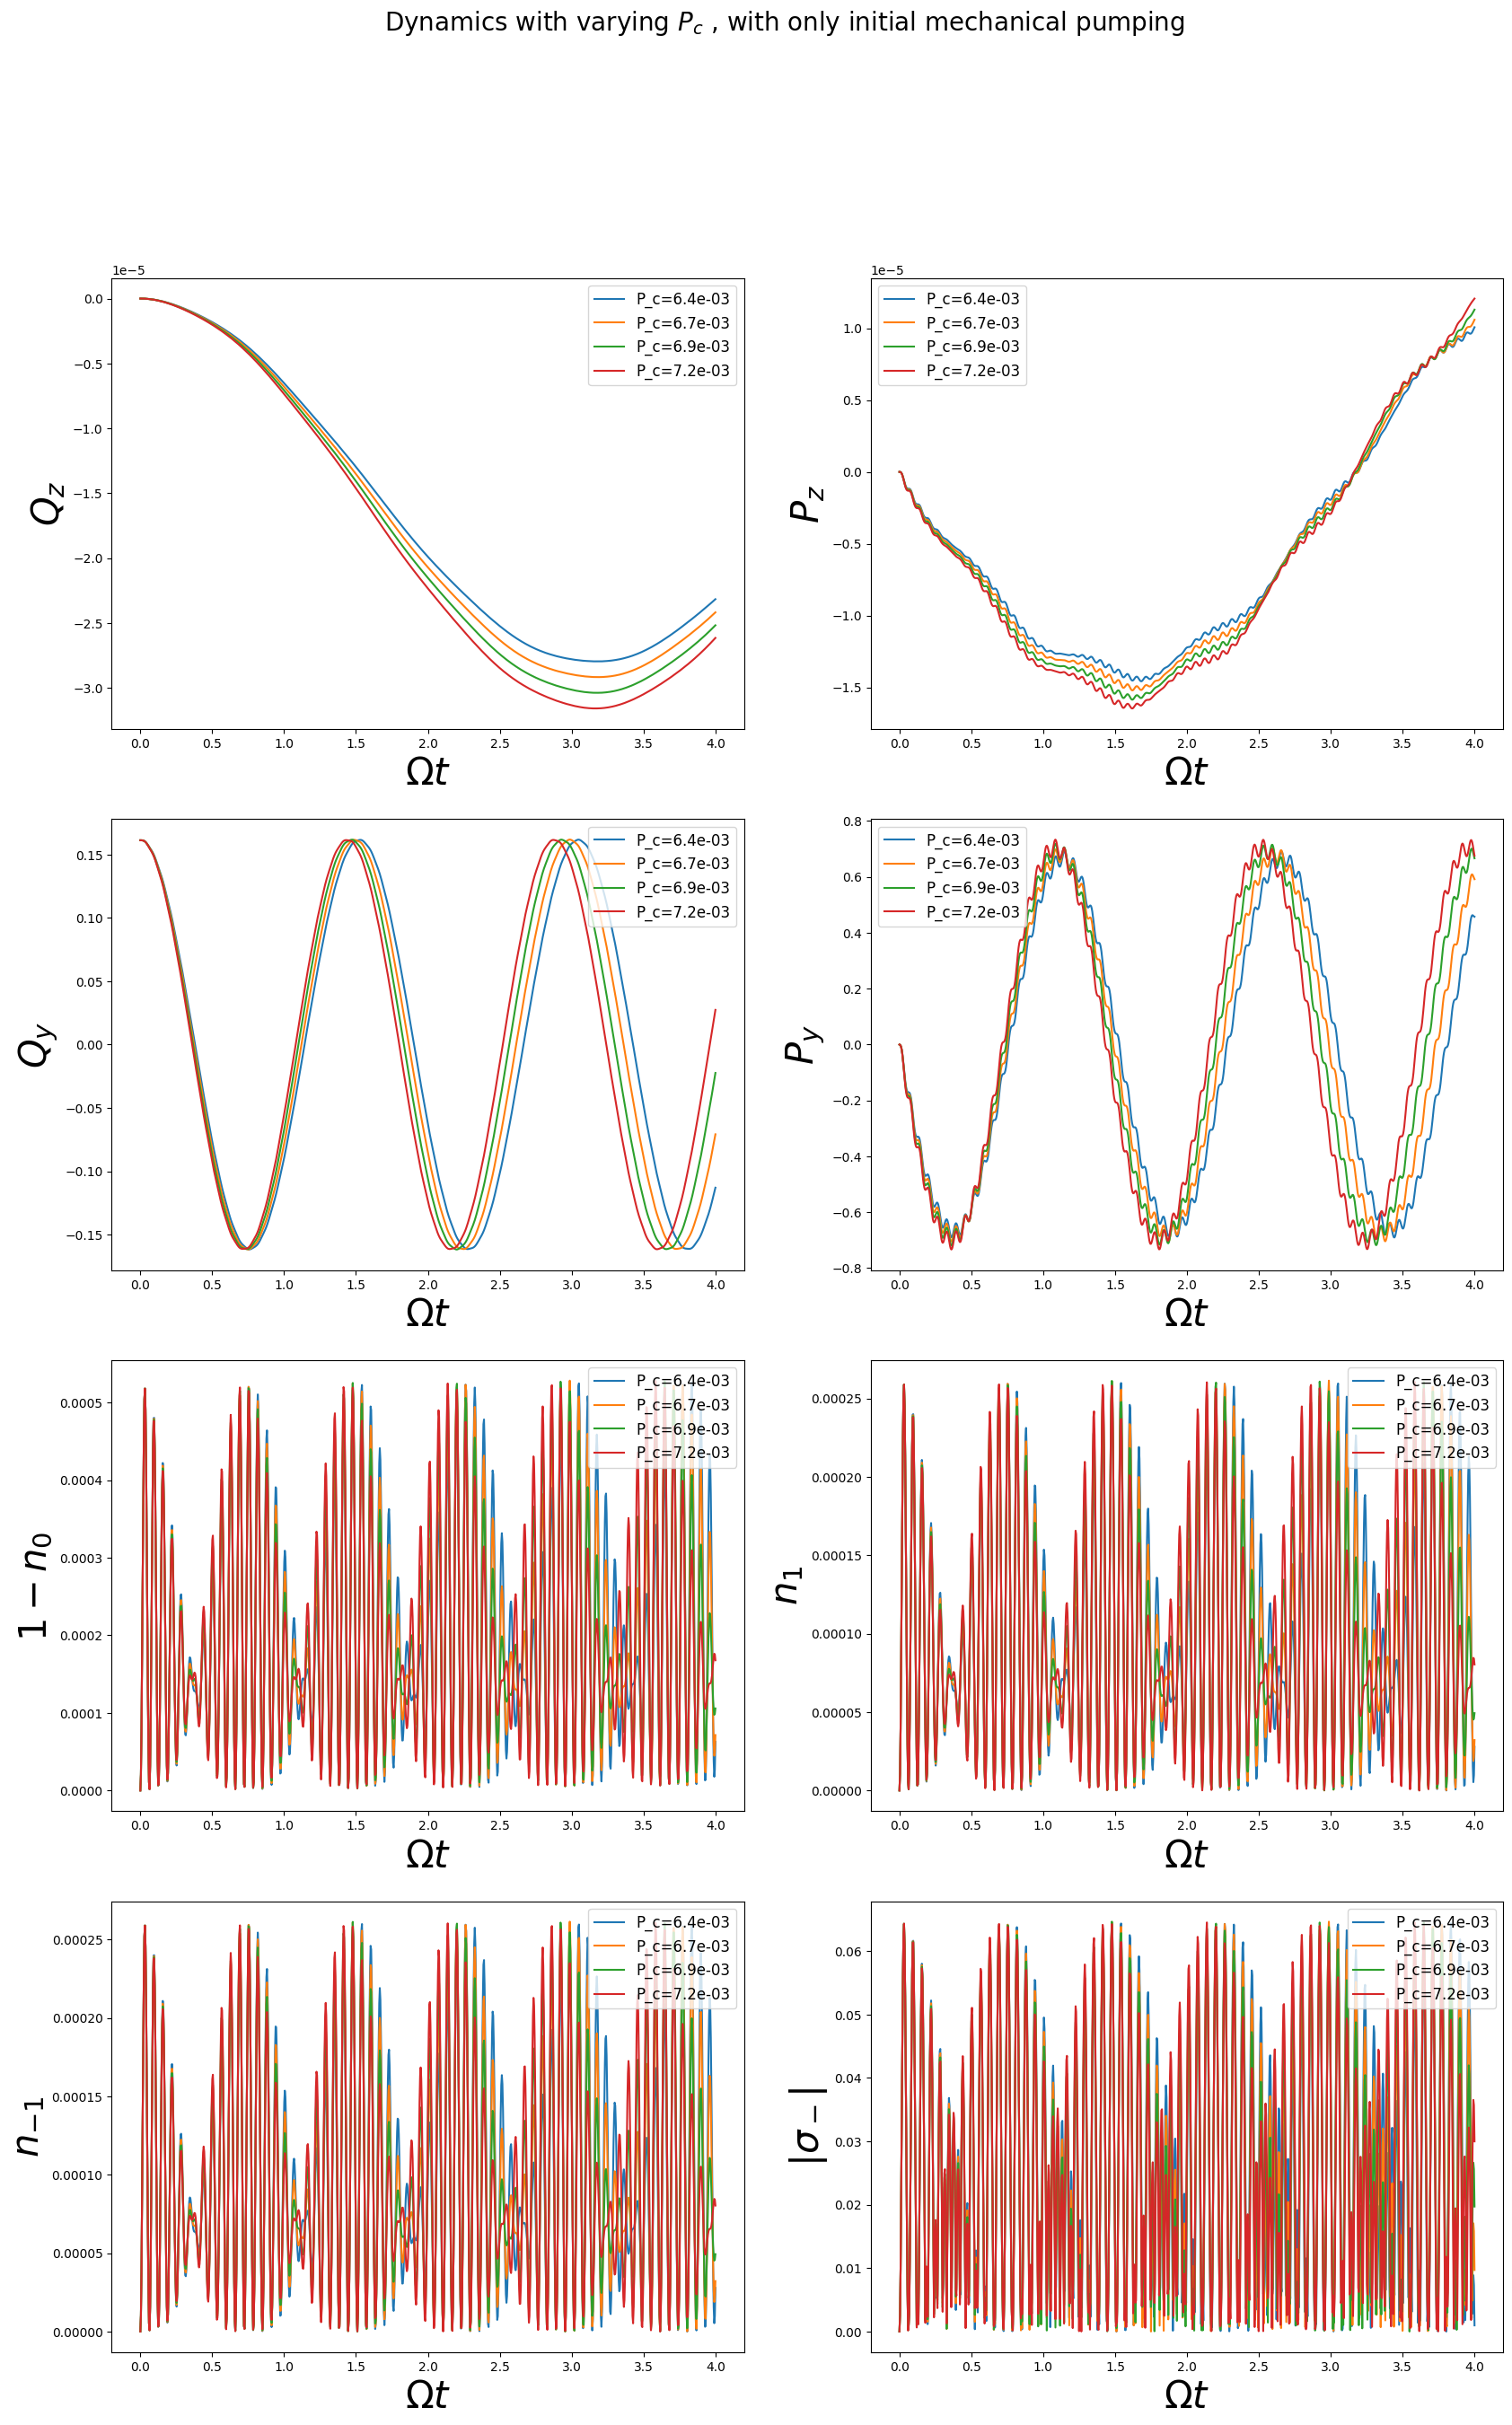

In [16]:
label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$1-n_0$","$n_1$","$n_{-1}$","$|\sigma_-|$"]

tf=4e0
N_step=1000
g_y=1e1
fig, axs = plt.subplots(4, 2,figsize=(20,30))
fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
N0_list=np.linspace(8,9,4)
x_0=[0.+0j,0.+0j,1.612*1e-1+0j,0.+0j]
psi_0=np.array([1+0j,0+0j,0+0j])

for N0 in (N0_list):
    param_list=[g_z0,g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=evolve(x_0,psi_0,tf,param_list,N_step,linear=False)
    for i in range(8):
        axs[i//2,i%2].plot(t,zz[i],label="P_c"+'='+"{:.1e}".format(Pc(param_list)))
for i in range(8):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
    axs[i//2,i%2].legend(fontsize=12)

plt.show() 

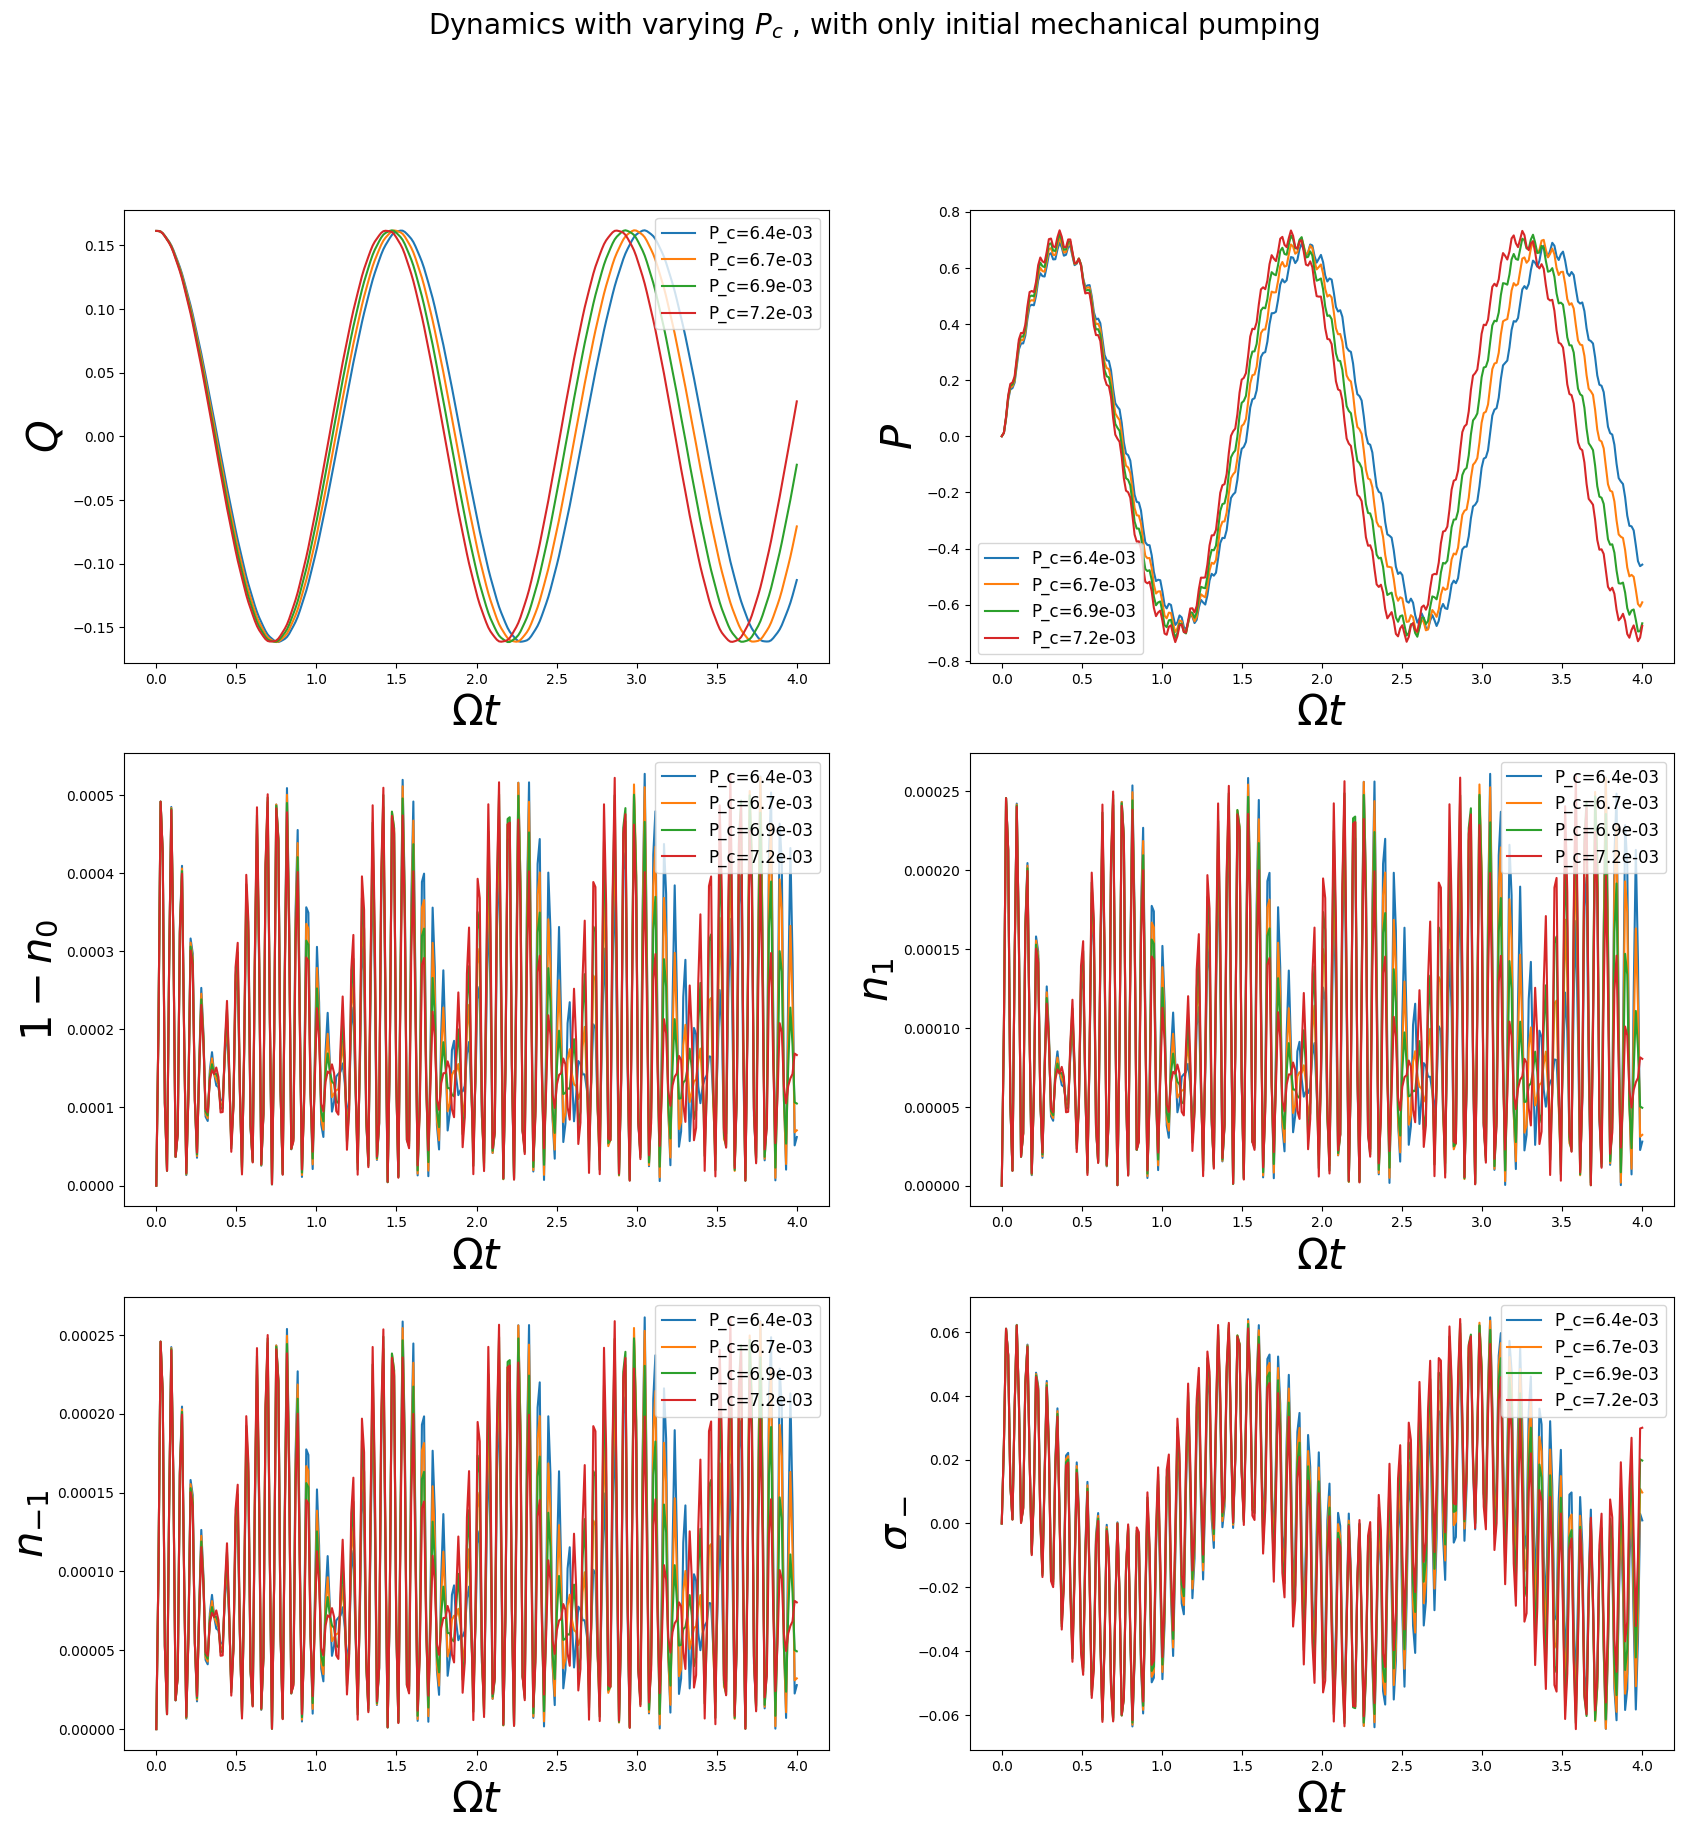

In [6]:
tf=4e0
N_step=300
g_y=1e1
fig, axs = plt.subplots(3, 2,figsize=(20,20))
fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
N0_list=np.linspace(8,9,4)
q_0,p_0=1.612*1e-1+0j,0.+0j
psi_0=np.array([1+0j,0+0j,0+0j])

for N0 in (N0_list):
    param_list=[g_z0,g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=evolve(q_0,p_0,psi_0,tf,param_list,N_step,linear=False)
    for i in range(6):
        axs[i//2,i%2].plot(t,zz[i],label="P_c"+'='+"{:.1e}".format(Pc(param_list)))
for i in range(6):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
    axs[i//2,i%2].legend(fontsize=12)

plt.show() 

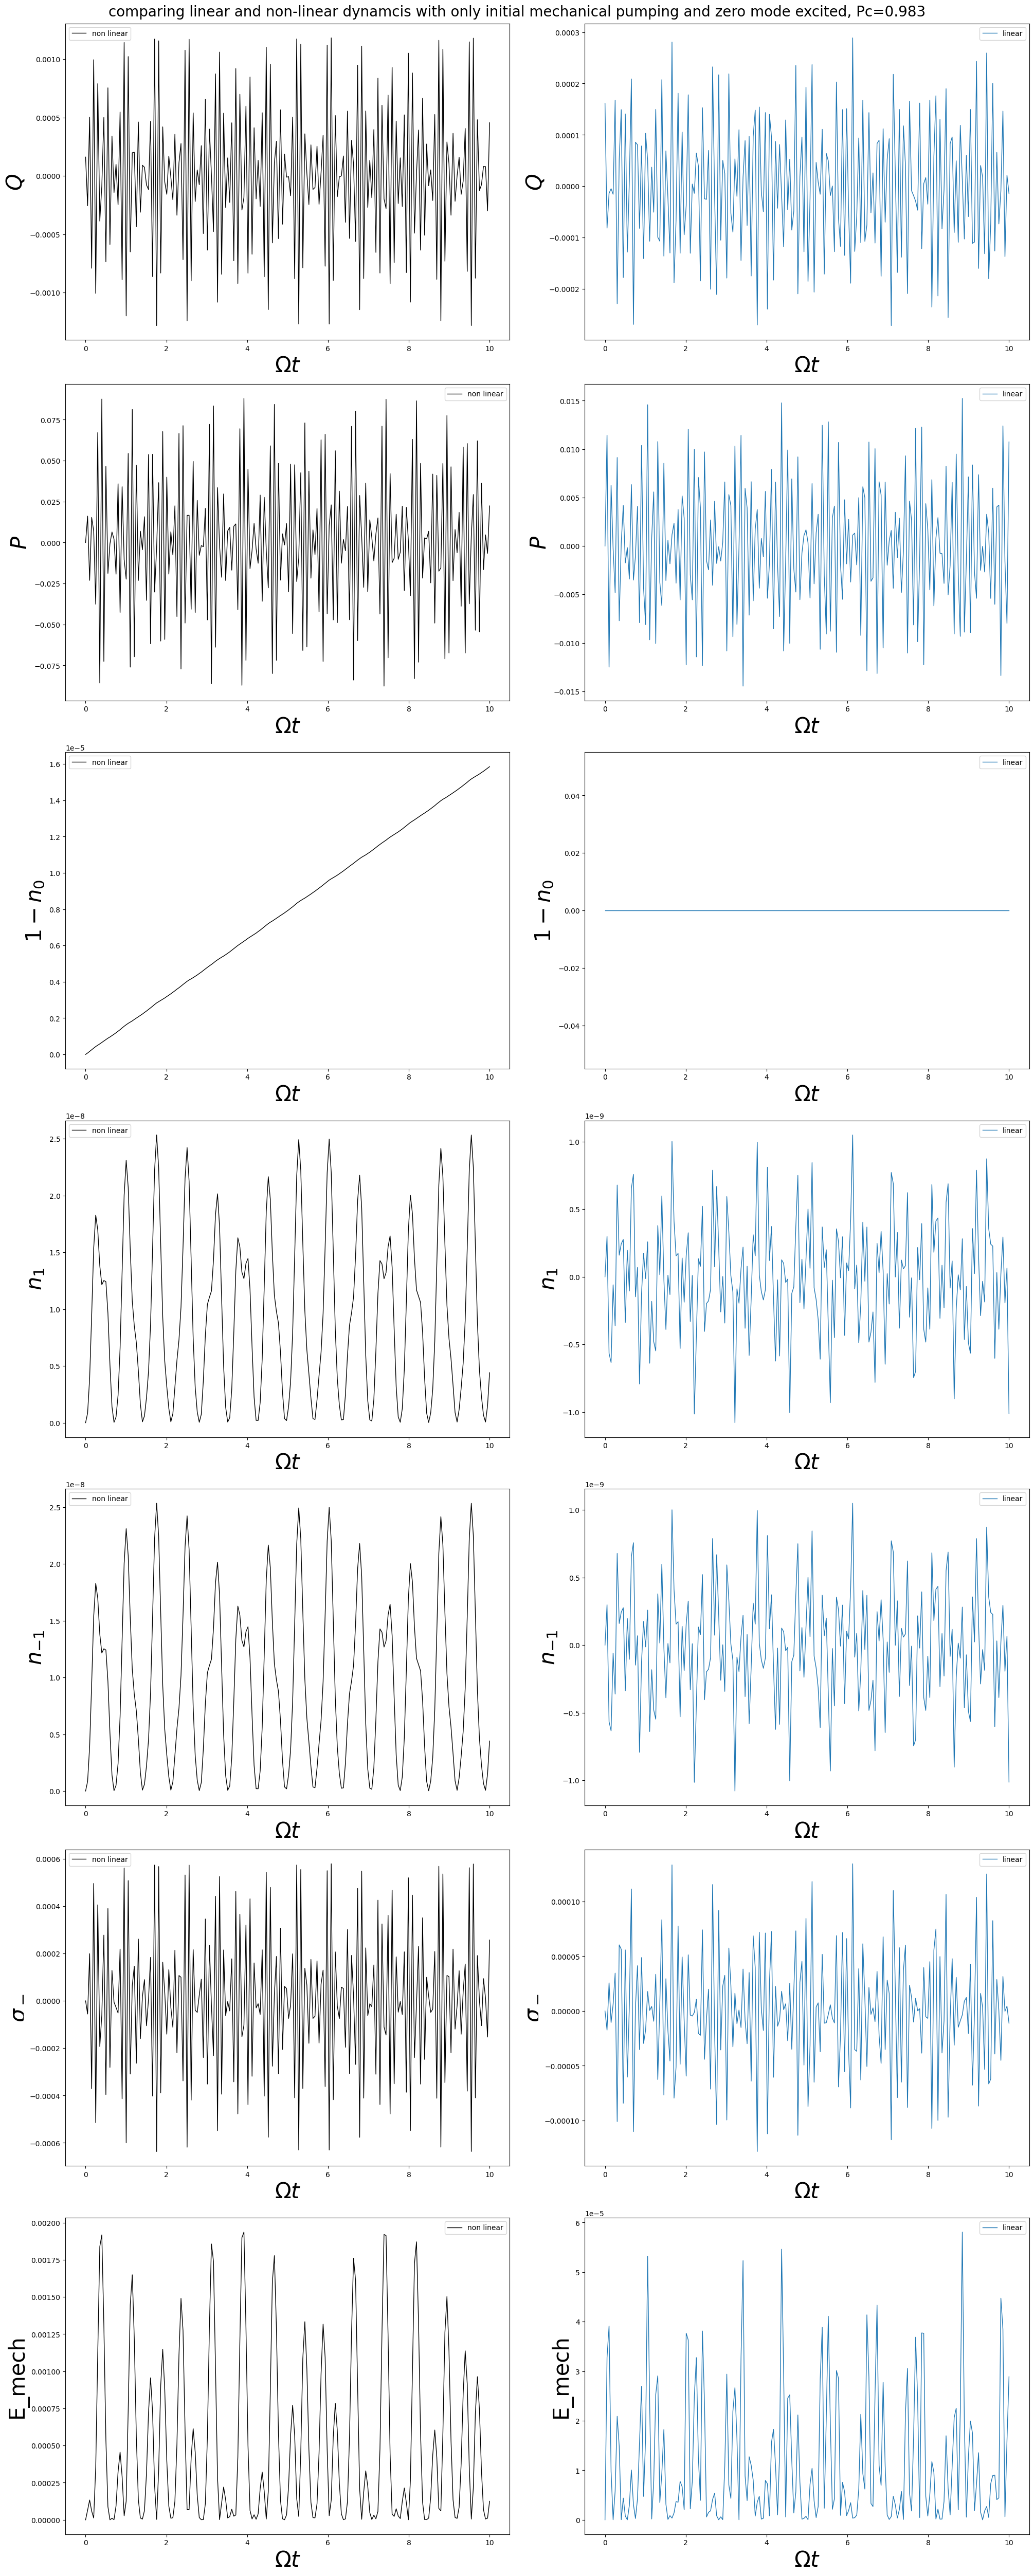

In [17]:
tf=1e1
g_y=1.24e7/ohm   ##Hz

q_0,p_0=1.612*1e-4+0j,0.+0j
psi_0=np.array([1+0j,0+0j,0+0j])
N_step=2*10**2
om=np.arange(N_step)
N0=800
param_list=[g_z0,g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq

zz_nl,t=evolve(q_0,p_0,psi_0,tf,param_list,N_step,linear=False)
zz_l,t=evolve(q_0,p_0,psi_0,tf,param_list,N_step,linear=True)
title="comparing linear and non-linear dynamcis with only initial mechanical pumping and zero mode excited, Pc={0}".format(np.round(Pc(param_list),3))
fig, axs = plt.subplots(7, 2,figsize=(20,50), constrained_layout=True)
fig.suptitle(title, fontsize=20)

for i in range(7):
    axs[i,0].plot(t,zz_nl[i],label="non linear",color='k',linewidth=1)
    axs[i,1].plot(t,zz_l[i],label="linear",linewidth=1)

for i in range(7):
    axs[i,0].set_ylabel(label_list[i],fontsize=30)
    axs[i,0].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,0].legend(fontsize=10)
    axs[i,1].set_ylabel(label_list[i],fontsize=30)
    axs[i,1].set_xlabel('$\Omega t$',fontsize=30)
    axs[i,1].legend(fontsize=10)
    
plt.show() 

In [18]:
def eig_eq(t,z,lam,nu,D,delta,g,N0):
    phi_1,p_1,phi_2,p_2=z
    a11=2*g**2*N0*lam*nu**2+3*lam**3*nu**4/delta
    a12=2*g**2*N0*(lam**3+2*nu**3)+lam**4*nu**2*(lam+2*nu)/delta+lam**5*delta
    a21=2*g**2*N0*lam**2*nu+3*lam**4*nu**3/delta
    a22=2*g**2*N0*(2*lam**3+nu**3)+lam**2*nu**4*(2*lam+nu)/delta+nu**5*delta
    
    phi_1_dot=p_1
    phi_2_dot=p_2
    p_1_dot=-phi_1*(a11*np.abs(phi_1)**2+a12*np.abs(phi_2)**2)/(2*delta*D*lam)
    p_2_dot=phi_2*(a21*np.abs(phi_2)**2+a22*np.abs(phi_1)**2)/(2*delta*D*nu)

    x_list=[phi_1_dot,p_1_dot,phi_2_dot,p_2_dot]
    return x_list

    
def eig_evol(z0,tf,param_list,N_step=300):
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(eig_eq, [0,tf],z0,args=param_list,dense_output=True,rtol = 1e-8, atol = 1e-8, t_eval=t)
    zz=xx.sol(t)
    sol=[]
    sol.extend( (np.real(zz[0]),np.real(zz[1]),np.real(zz[2]),np.real(zz[3])) )
    return sol,t




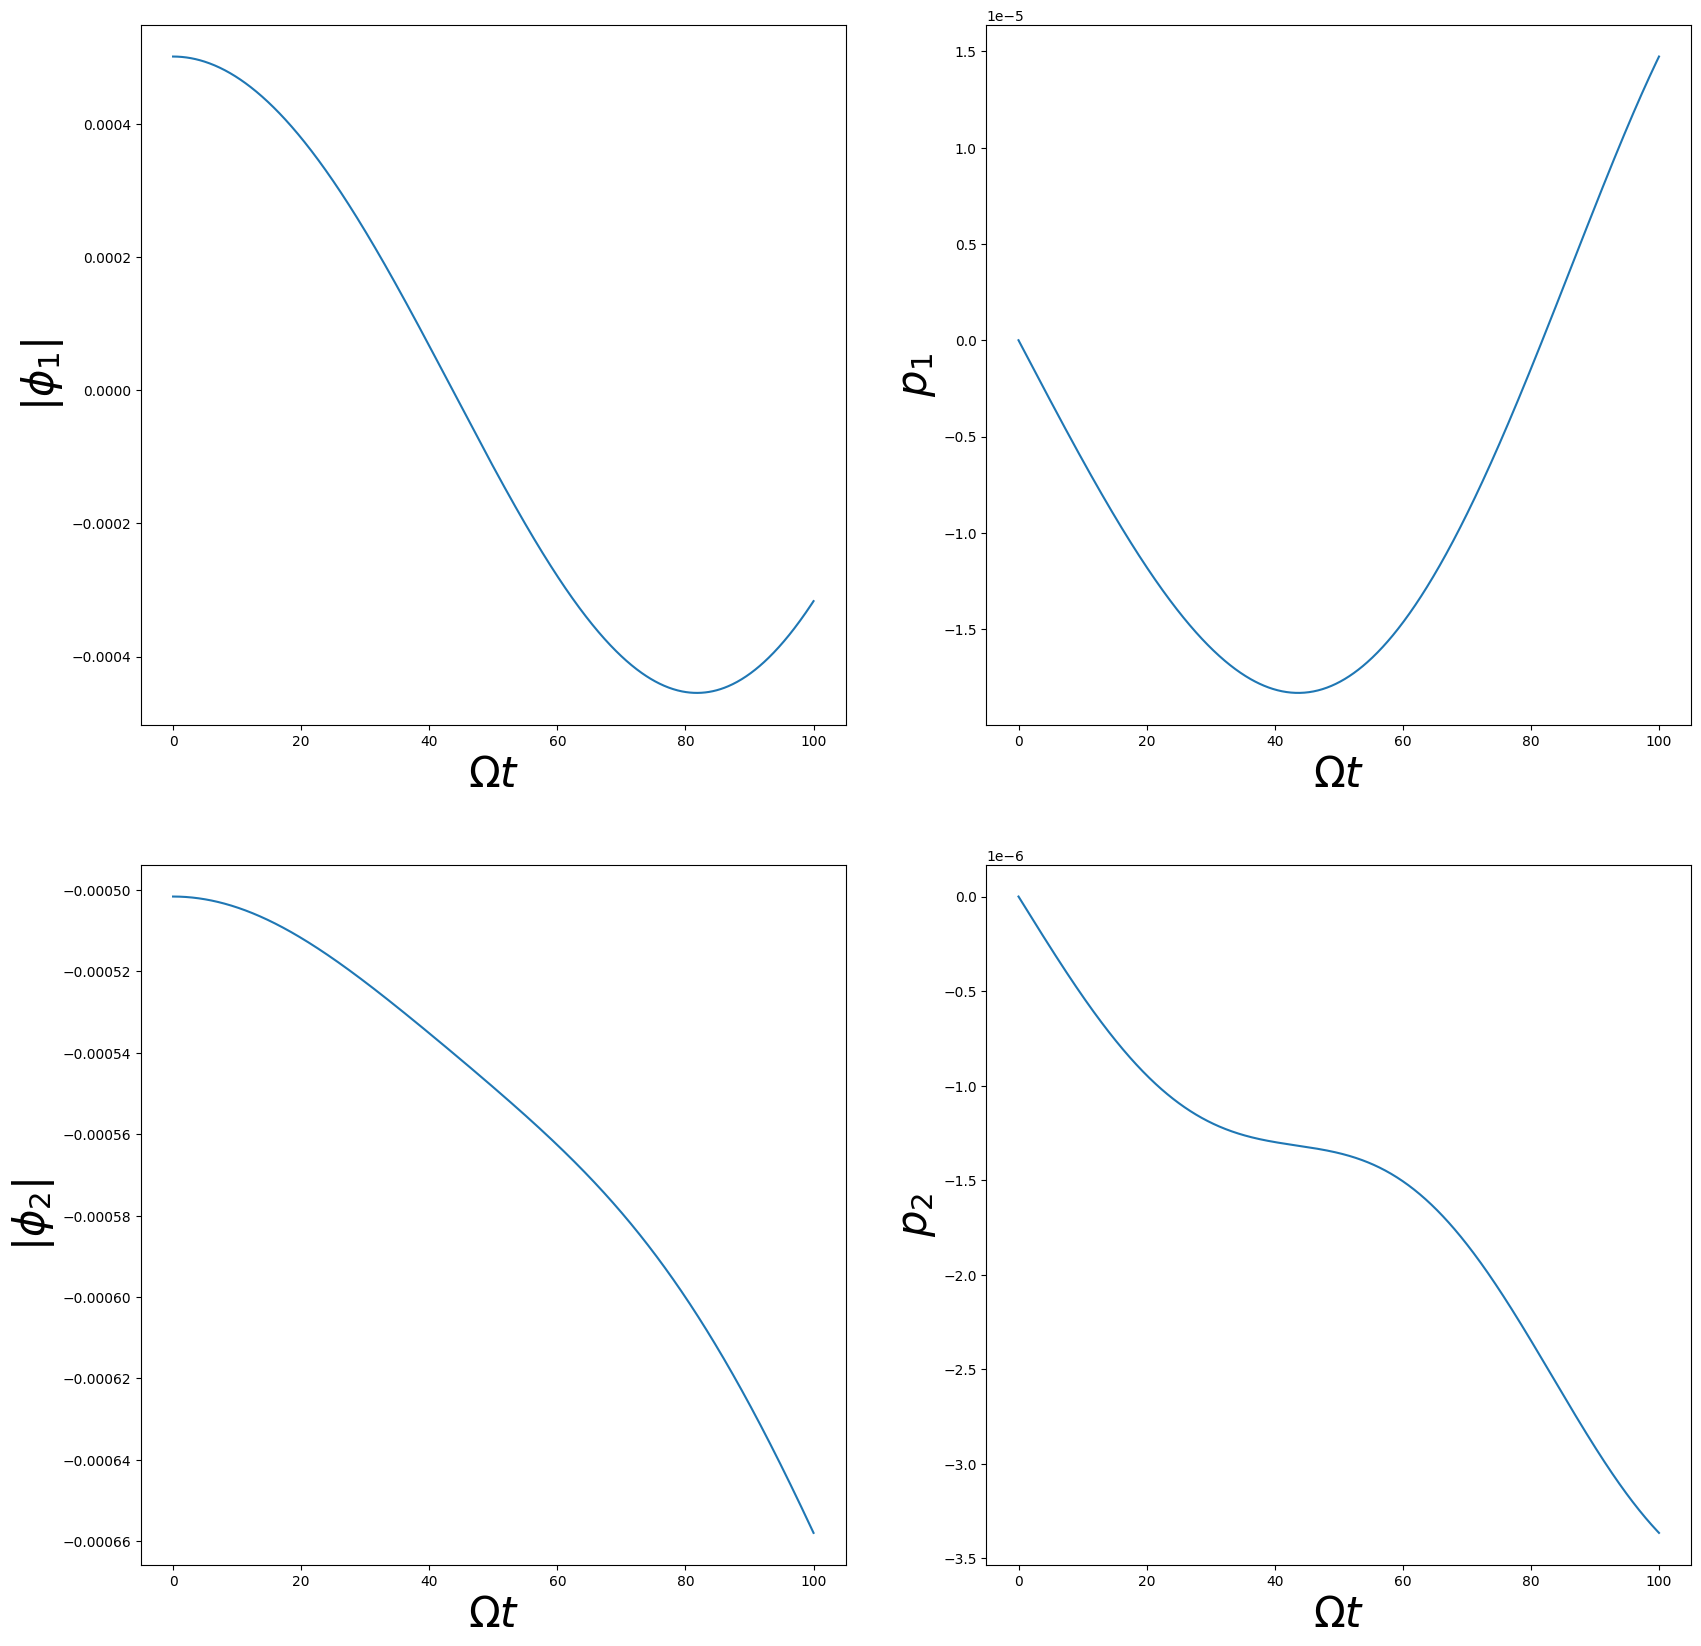

In [35]:
label_list=["$|\phi_1|$","$p_1$","$|\phi_2|$","$p_2$"]
delta=del_omega
g=1e1
tf=1e2
N_step=1000
N0=8
q0=1e-2
D=((1-delta**2)**2-8*g**2*N0*delta)**0.5
lam=((delta**2+(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
nu=((delta**2-(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5

z0=(delta*g/(2*D))*np.array([1,0,-1,0])*q0


param_list=[lam,nu,D,delta,g,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=eig_evol(z0,tf,param_list,N_step)

fig, axs = plt.subplots(2, 2,figsize=(20,20))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
for i in range(4):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

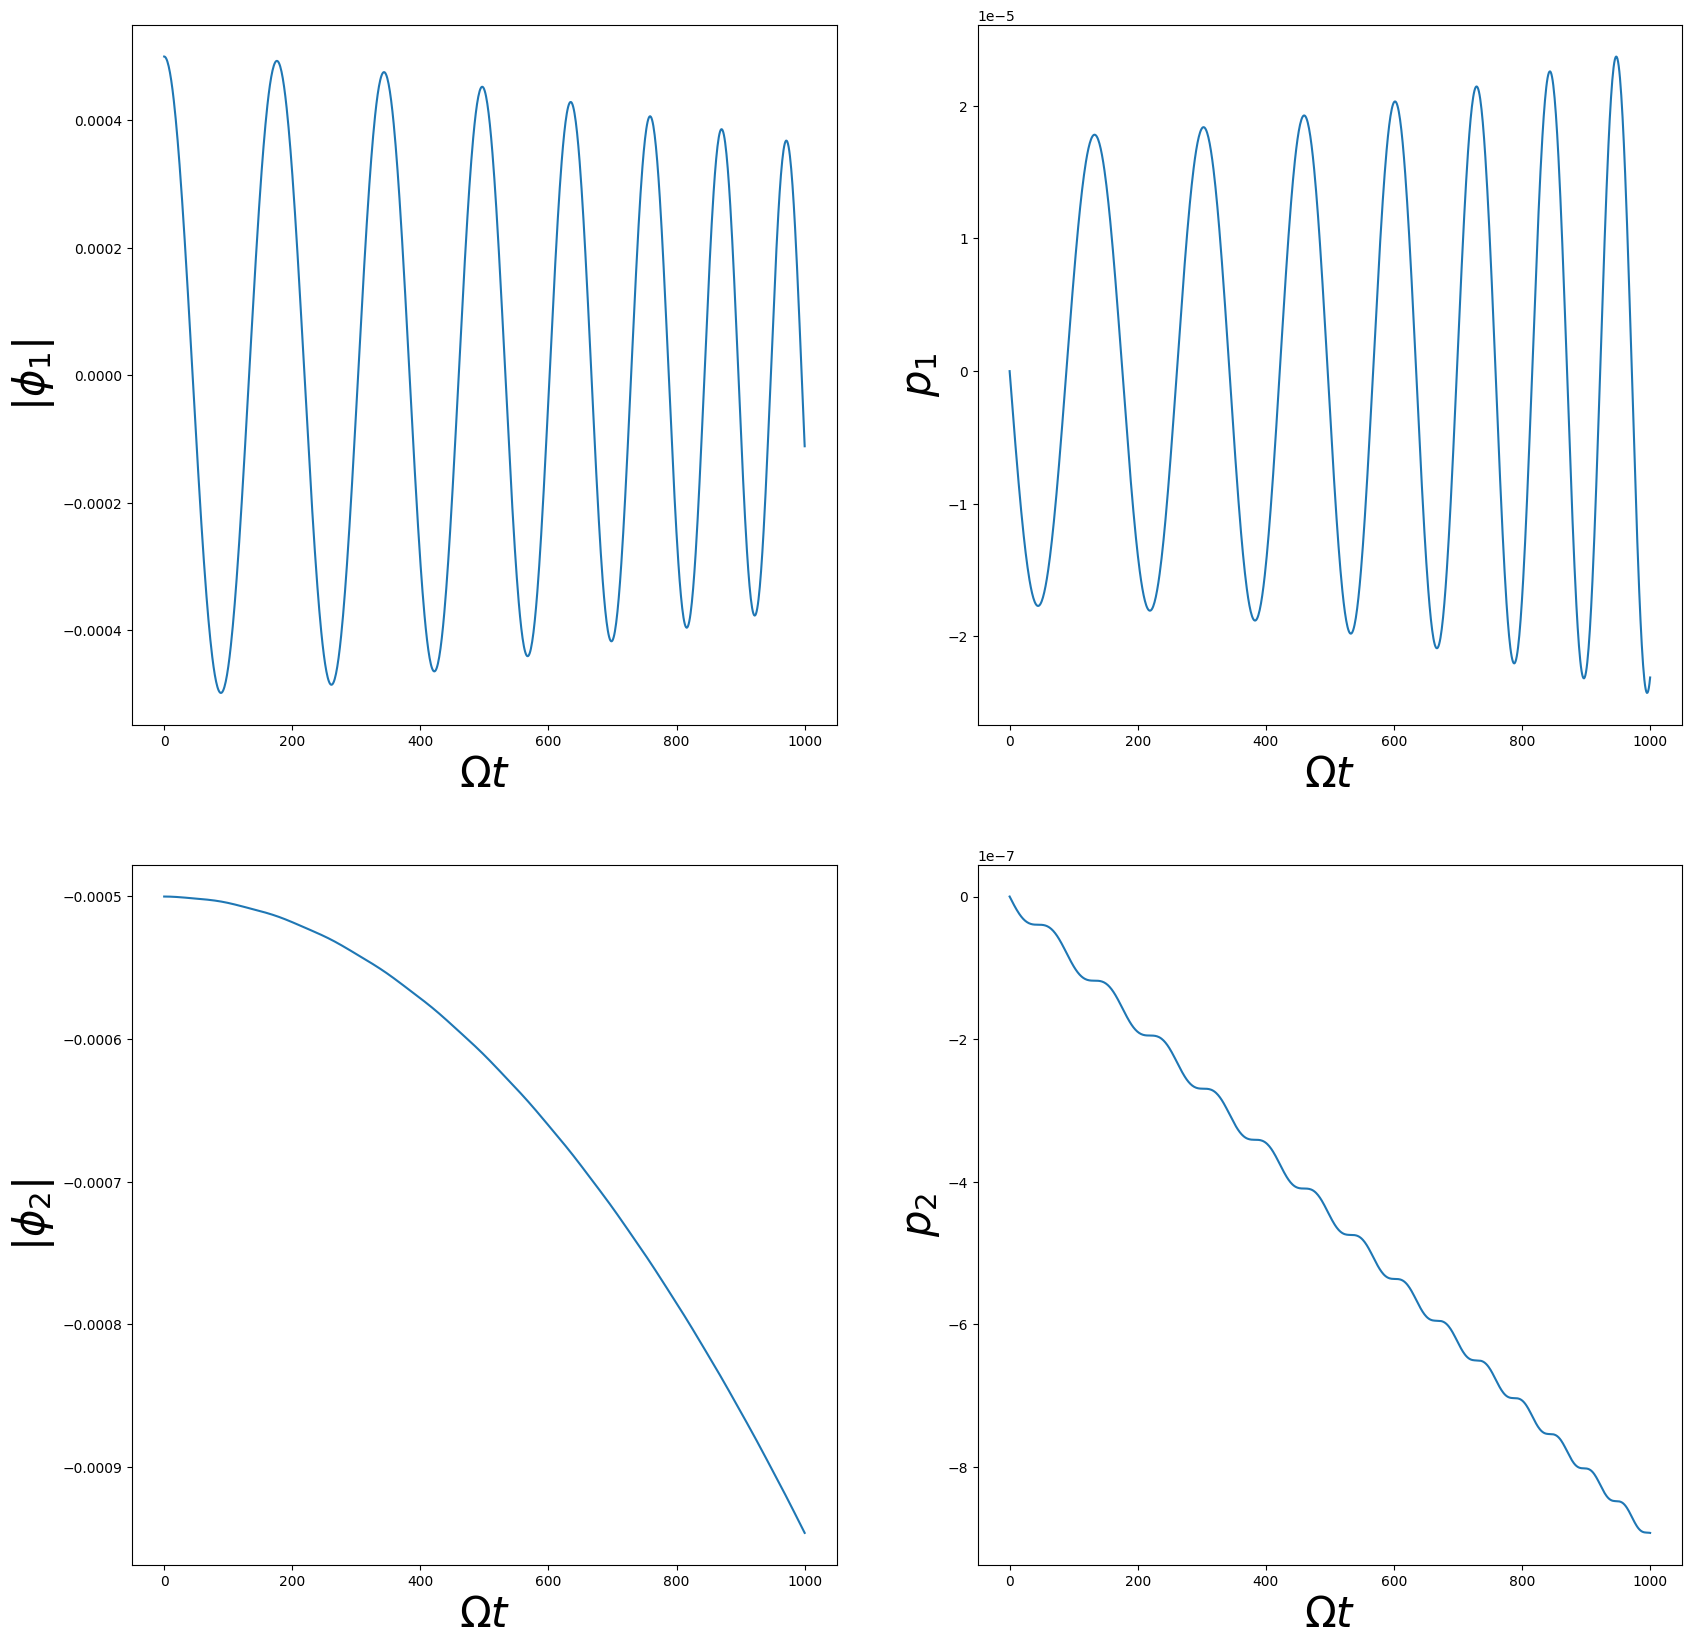

In [36]:
label_list=["$|\phi_1|$","$p_1$","$|\phi_2|$","$p_2$"]
delta=del_omega
g=1e0
tf=7e2
N_step=1000
N0=1
q0=1e-1
D=((1-delta**2)**2-8*g**2*N0*delta)**0.5
lam=((delta**2+(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
nu=((delta**2-(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5

z0=(delta*g/(2*D))*np.array([1,0,-1,0])*q0


param_list=[lam,nu,D,delta,g,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=eig_evol(z0,tf,param_list,N_step)

fig, axs = plt.subplots(2, 2,figsize=(20,20))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
for i in range(4):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

In [25]:
def eig_eq2(t,z,lam,nu,D,delta,g,g_z1,N0):
    phi_1,phi_1_d,phi_2,phi_2_d,A_p,A_m,u_z,p_z=z
    phi_1_dot= (4*(2*delta*g**2*N0*A_m-1j*g*u_z*lam**3)*(lam*(phi_1-phi_1_d*np.exp(2j*lam*t))
                +nu*(phi_2*np.exp(-1j*(nu-lam)*t)-phi_2_d*np.exp(1j*(nu+lam)*t)) )
                +4*lam**2*(nu**2*(phi_1+phi_1_d*np.exp(2j*lam*t))+lam**2*(phi_2*np.exp(-1j*t*(nu-lam))
                +phi_2_d*np.exp(1j*t*(nu+lam))))*(lam*A_m+1j*delta*A_p)
                +4j*delta**2*(phi_1+phi_1_d*np.exp(2j*lam*t)+phi_2*np.exp(-1j*(nu-lam)*t)
                +phi_2_d*np.exp(1j*(nu+lam)*t))*(2*g**2*N0*A_p-lam**2*g*u_z) )/(8*delta*D*lam)
    
    phi_1_d_dot= (-4*(2*delta*g**2*N0*A_m+1j*g*u_z*lam**3)*(lam*(-phi_1_d+phi_1*np.exp(-2j*lam*t))
                +nu*(phi_2*np.exp(-1j*(nu+lam)*t)-phi_2_d*np.exp(1j*(nu-lam)*t)) )
                +4*lam**2*(nu**2*(phi_1_d+phi_1*np.exp(-2j*lam*t))+lam**2*(phi_2*np.exp(-1j*t*(nu+lam))
                +phi_2_d*np.exp(1j*t*(nu-lam))))*(lam*A_m-1j*delta*A_p)
                -4j*delta**2*(phi_1_d+phi_1*np.exp(-2j*lam*t)+phi_2*np.exp(-1j*(nu+lam)*t)
                +phi_2_d*np.exp(1j*(nu-lam)*t))*(2*g**2*N0*A_p-lam**2*g*u_z) )/(8*delta*D*lam)
    
    phi_2_dot=-(4*(lam*(phi_1*np.exp(-1j*(lam-nu)*t)-phi_1_d*np.exp(1j*(nu+lam)*t))
                +nu*(phi_2-phi_2_d*np.exp(2j*nu*t)))*(2*delta*g**2*N0*A_m-1j*g*u_z*nu**3) 
               +4*nu**2*(nu**2*(phi_1*np.exp(-1j*(lam-nu)*t)+phi_1_d*np.exp(1j*(lam+nu)*t))
                +lam**2*(phi_2_d*np.exp(2j*nu*t)+phi_2))*(nu*A_m+1j*delta*A_p)
               +4j*delta**2*(phi_2_d*np.exp(2j*nu*t)+phi_2+phi_1*np.exp(-1j*(lam-nu)*t)
                +phi_1_d*np.exp(1j*(lam+nu)*t))*(2*g**2*N0*A_p-nu**2*g*u_z))/(8*delta*D*nu)
    
    phi_2_d_dot=(4*(lam*(phi_1*np.exp(-1j*(lam+nu)*t)-phi_1_d*np.exp(1j*(lam-nu)*t))
                +nu*(-phi_2_d+phi_2*np.exp(-2j*nu*t)))*(2*delta*g**2*N0*A_m+1j*g*u_z*nu**3) 
               -4*nu**2*(nu**2*(phi_1*np.exp(-1j*(lam+nu)*t)+phi_1_d*np.exp(1j*(lam-nu)*t))
                +lam**2*(phi_2*np.exp(-2j*nu*t)+phi_2_d))*(nu*A_m-1j*delta*A_p)
               +4j*delta**2*(phi_2*np.exp(-2j*nu*t)+phi_2_d+phi_1*np.exp(-1j*(lam+nu)*t)
                +phi_1_d*np.exp(1j*(lam-nu)*t))*(2*g**2*N0*A_p-nu**2*g*u_z))/(8*delta*D*nu)
    
    A_p_dot=1j*(lam*nu**2*(phi_1**2*np.exp(-2j*lam*t)-phi_1_d**2*np.exp(2j*lam*t))
                +nu*lam**2*(phi_2**2*np.exp(-2j*nu*t)-phi_2_d**2*np.exp(2j*nu*t))
               +(lam**3+nu**3)*(phi_1*phi_2*np.exp(-1j*(lam+nu)*t)-phi_1_d*phi_2_d*np.exp(1j*(lam+nu)*t))
               +(lam**3-nu**3)*(phi_1_d*phi_2*np.exp(1j*(lam-nu)*t)-phi_1*phi_2_d*np.exp(-1j*(lam-nu)*t))
               )/delta**2
    A_m_dot=-(nu**2*(phi_1**2*np.exp(-2j*lam*t)+phi_1_d**2*np.exp(2j*lam*t))+lam**2*(phi_2**2*np.exp(-2j*nu*t)
            +phi_2_d**2*np.exp(2j*nu*t))+nu**2*phi_1*phi_1_d+lam**2*phi_2*phi_2_d
             +delta**2*(phi_1*phi_2*np.exp(-1j*(lam+nu)*t)+phi_1_d*phi_2*np.exp(1j*(lam-nu)*t)
            +phi_1*phi_2_d*np.exp(-1j*(lam-nu)*t)+phi_1_d*phi_2_d*np.exp(1j*(lam+nu)*t))/2
             )/delta
    u_z_dot=p_z
    p_z_dot=-u_z-g_z1*N0*(-delta*(phi_1**2*np.exp(-2j*lam*t)+phi_1_d**2*np.exp(2j*lam*t)
            +phi_2**2*np.exp(-2j*nu*t)+phi_2_d**2*np.exp(2j*nu*t))+phi_1*phi_1_d*(delta+D)
            +phi_2*phi_2_d*(delta-D)+2*(1-lam*nu/delta)*(phi_1*phi_2*np.exp(-1j*(lam+nu)*t)
            +phi_1_d*phi_2_d*np.exp(1j*(lam+nu)*t))+2*(1+lam*nu/delta)*(phi_1_d*phi_2*np.exp(1j*(lam-nu)*t)
            +phi_1*phi_2_d*np.exp(-1j*(lam-nu)*t)) )
    x_list=[phi_1_dot,phi_1_d_dot,phi_2_dot,phi_2_d_dot,A_p_dot,A_m_dot,u_z_dot,p_z_dot]
    return x_list

    
def eig_evol2(z0,tf,param_list,N_step=300):
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(eig_eq2, [0,tf],z0,args=param_list,dense_output=True,rtol = 1e-8, atol = 1e-8, t_eval=t)
    zz=xx.sol(t)
    sol=[]
    sol.extend( (np.abs(zz[0]),np.abs(zz[2])) )
    return sol,t




0.4308869380063768 100.0


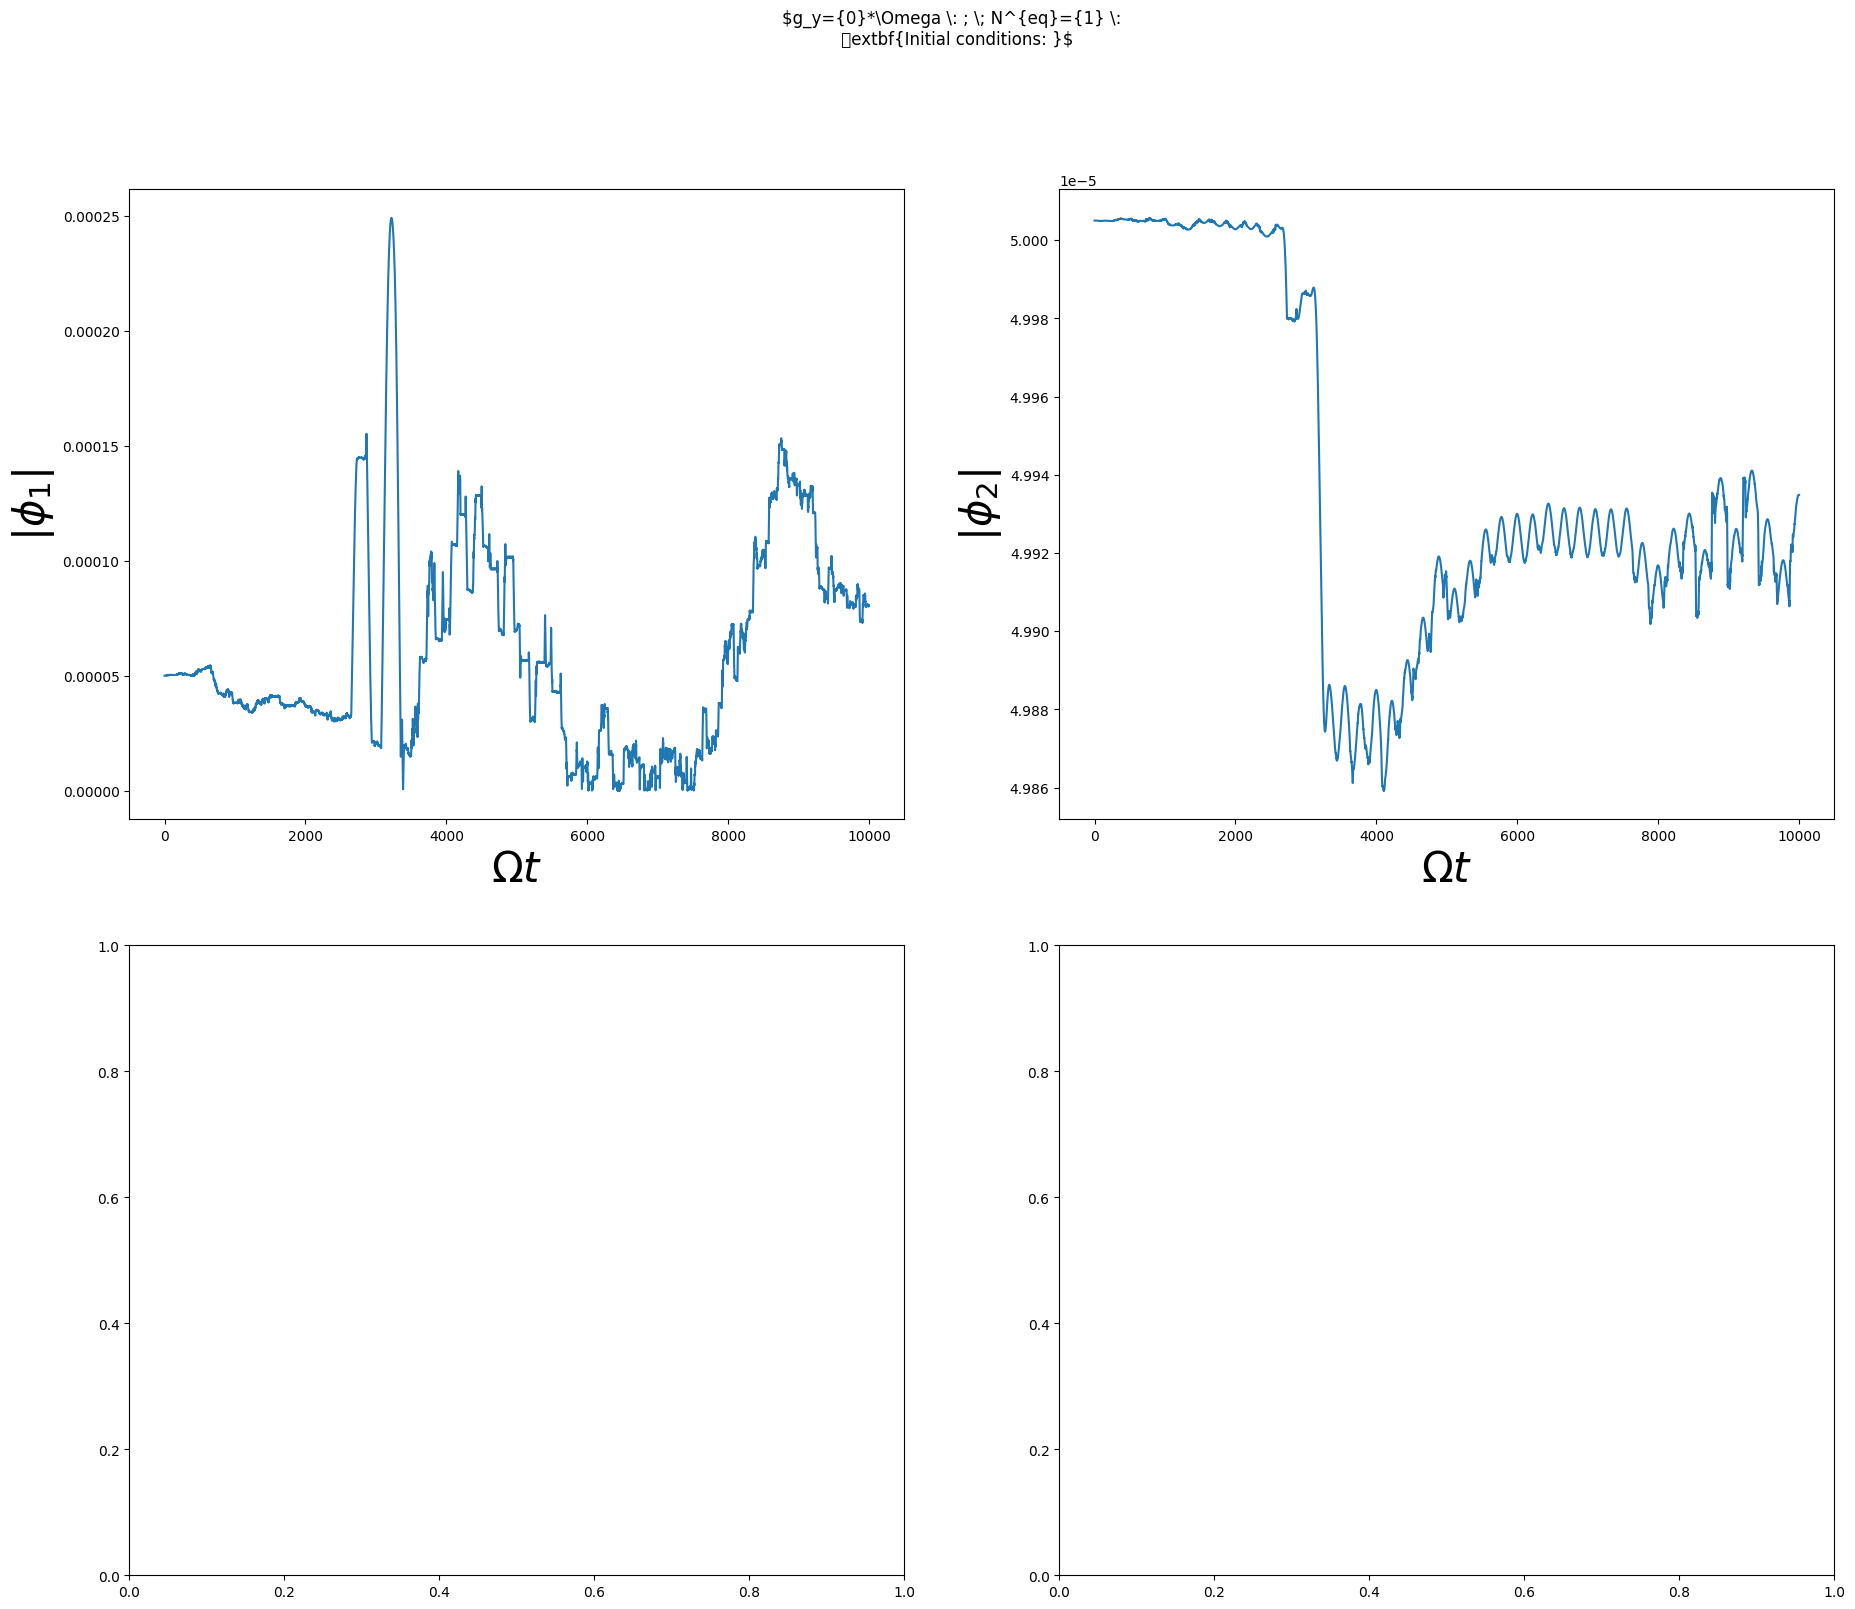

In [64]:
label_list=["$|\phi_1|$","$|\phi_2|$"]
delta=del_omega
g=1e-1
tf=1e4
N_step=10000
N0=1
q0=1e-1
D=((1-delta**2)**2-8*g**2*N0*delta)**0.5
lam=((delta**2+(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
nu=((delta**2-(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
delta_0=(8*g**2*N0)**(1/3)
print(delta_0,delta)
z0=(delta*g/(2*D))*np.array([1,1,-1,-1,0,0,0,0])*q0


param_list=[lam,nu,D,delta,g,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=eig_evol2(z0,tf,param_list,N_step)

fig, axs = plt.subplots(2, 2,figsize=(22,18))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
fig.suptitle('$g_y={0}\Omega  \: ; \: N_0={1} $'.format(g,N0), fontsize=20)
for i in range(2):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

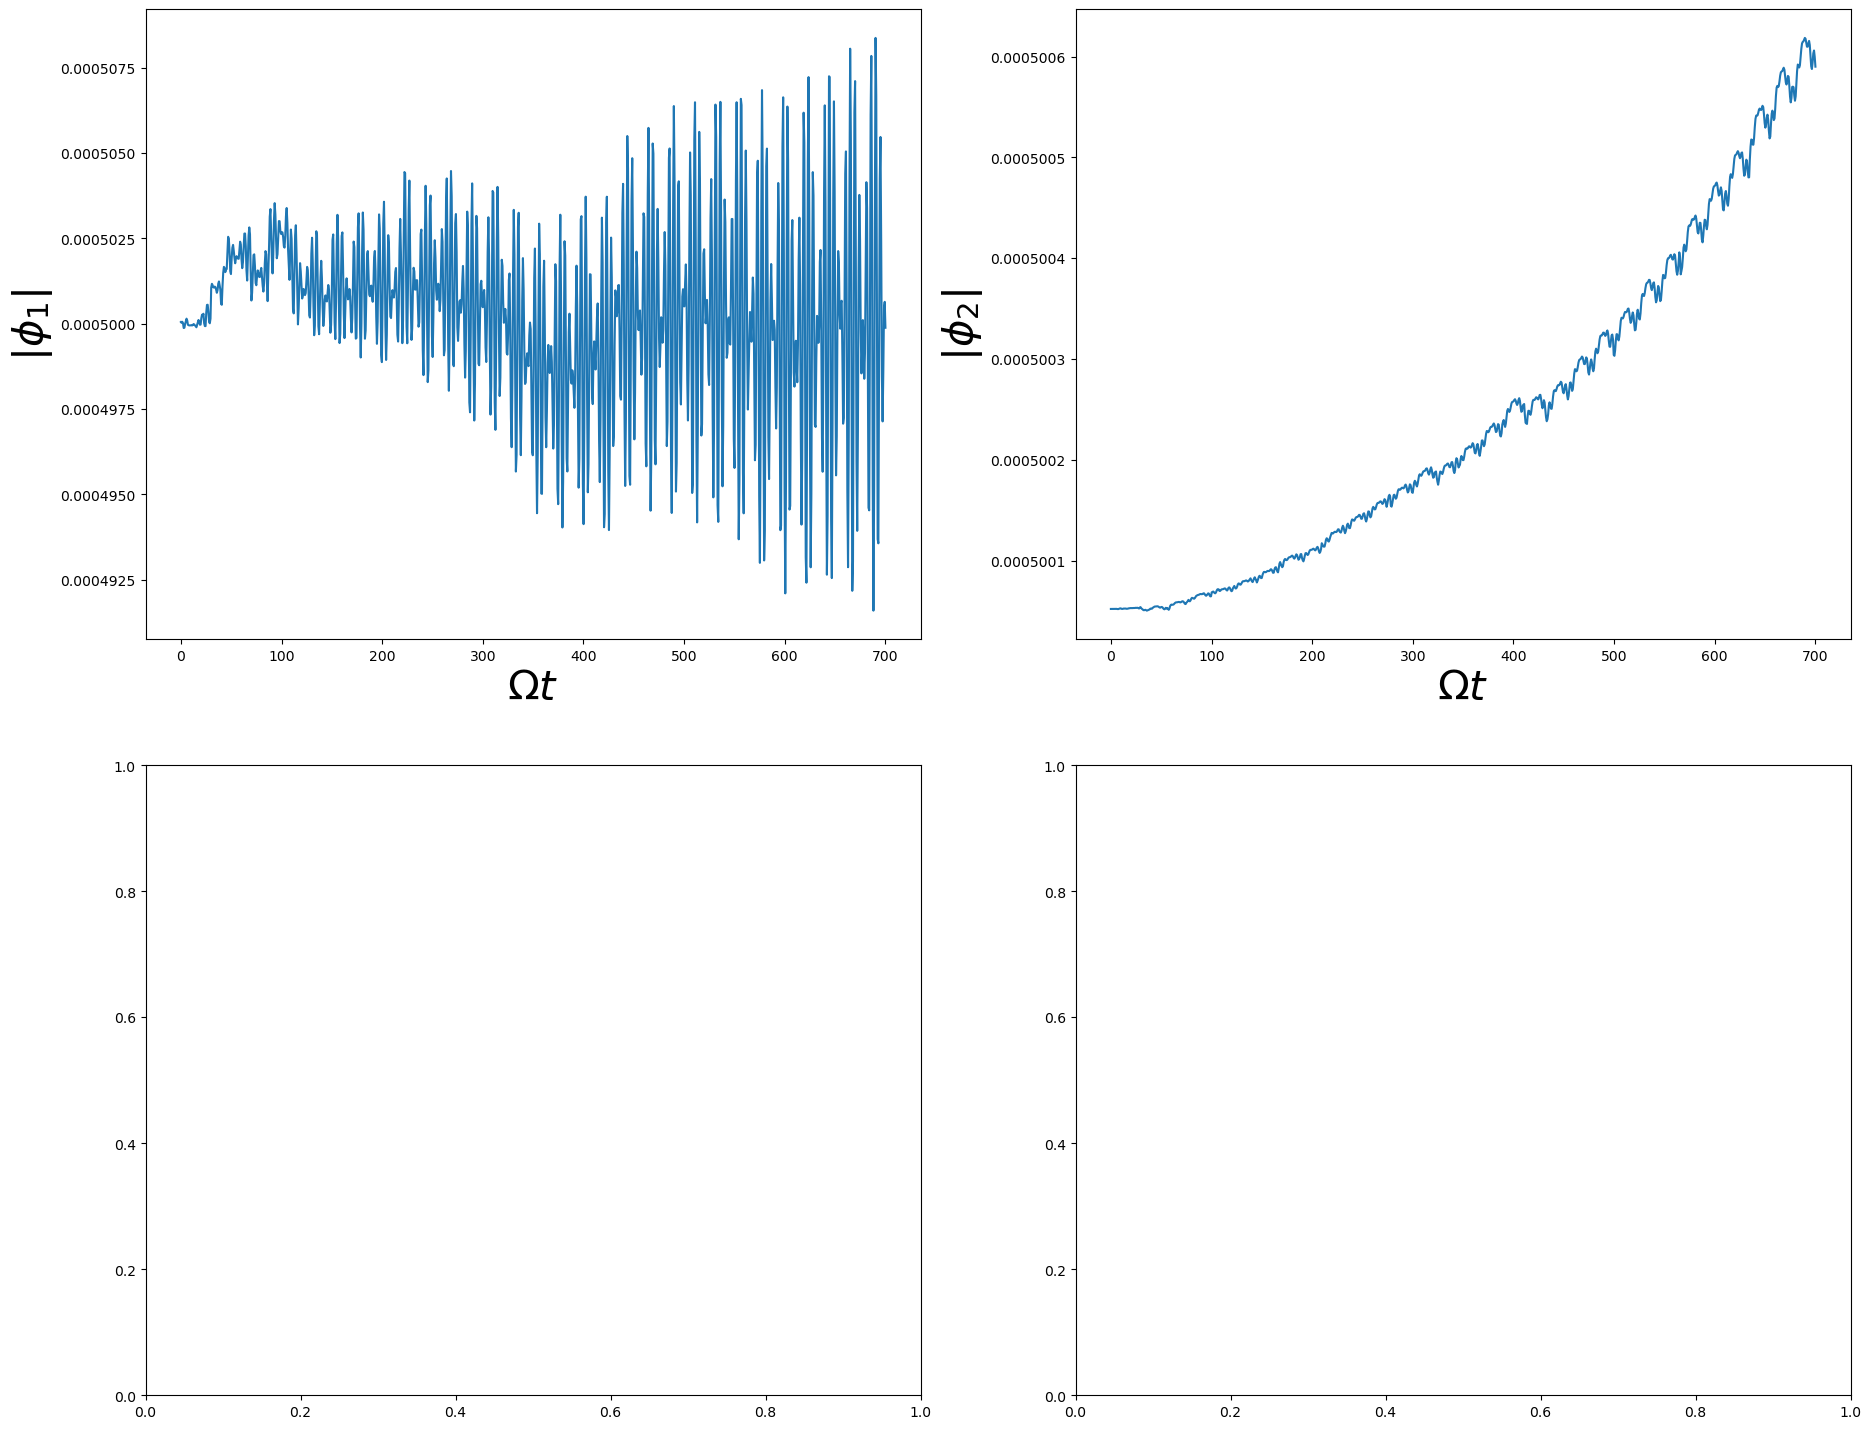

In [35]:
label_list=["$|\phi_1|$","$|\phi_2|$"]
delta=del_omega
g=1e0
tf=7e2
N_step=1000
N0=1
q0=1e-1
D=((1-delta**2)**2-8*g**2*N0*delta)**0.5
lam=((delta**2+(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
nu=((delta**2-(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
delta_0=(8*g**2*N0)**(1/3)
z0=(delta*g/(2*D))*np.array([1,1,-1,-1,0,0,0,0])*q0


param_list=[lam,nu,D,delta,g,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=eig_evol2(z0,tf,param_list,N_step)

fig, axs = plt.subplots(2, 2,figsize=(22,18))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
for i in range(2):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

In [77]:
def eig_eq3(t,z,lam,nu,D,delta,g,g_z1,N0):
    psi_1,psi_2,psi_3,psi_4,A_p,A_m,u_z,p_z=z
    psi=np.array([psi_1,psi_2,psi_3,psi_4]).reshape(4,1)
    w=U@psi
    nl=np.array([0,-2*g*N0*(A_m*w[2]-A_p*w[3]),-g_z1*u_z*w[3]-g*w[0]*A_p,-g_z1*u_z*w[2]-g*w[0]*A_m]).reshape(4,1)
    psi_dot=np.diag([-1j*lam,1j*lam,-1j*nu,1j*nu])@psi+U_inv@nl
    
    
    u_z_dot=p_z
    p_z_dot=-u_z-g_z1*N0*(w[2]**2+w[3]**2)
    A_p_dot=g*w[0]*w[2]/2
    A_m_dot=g*w[0]*w[3]/2
    
    psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot=psi_dot[:,0]
#     print(psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot,psi_1,psi_2,psi_3,psi_4)
    x_list=[psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot,A_p_dot,A_m_dot,u_z_dot,p_z_dot]
    return x_list

    
def eig_evol3(z0,tf,param_list,N_step=300):
    def energy(yy):
        q_y=yy[0]
        p_y=yy[1]
        A1_p=yy[2]
        A1_m=yy[3]
        A0_p=yy[4]
        A0_m=yy[5]
        q_z=yy[6]
        p_z=yy[7]
        E=N0*(1+2*A0_p+A0_p**2+A0_m**2)*(del_omega+(g_z0-g_z1)*q_z)+q_z*g_z1*N0
        +(q_y**2+p_y**2+q_z**2+p_z**2)+q_y*g_y*N0*(A1_m+A1_m*A0_p-A1_p*A0_m)
        return E

    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(eig_eq3, [0,tf],z0,args=param_list,dense_output=True,rtol = 1e-8, atol = 1e-8, t_eval=t)
    zz=xx.sol(t)
    yy=eig_to_real(zz)
    H=energy(yy)
    Num=(1+2*yy[4]+yy[4]**2+yy[5]**2)+(yy[2]**2+yy[3]**2)
#     Num=yy[3]
    sol=[]
    sol.extend( (np.real(zz[0]),np.real(zz[1]),np.real(zz[2]),np.real(zz[3]),np.real(yy[6]),np.real(yy[7]),H,Num) )
    return sol,t


def eig_to_real(zz):
    temp=np.array(zz,dtype=complex)
    print(np.shape(temp))
    N_step=len(zz[0])
    yy=[]
    for i in range(N_step):
        yy.append(U@zz[:4,i])
    temp[:4]=np.array(yy).T
    return temp 

/var/folders/98/5wcykpls4kd1dcm4775b11cj50qjlt/T/ipykernel_5464/2021506295.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nl=np.array([0,-2*g*N0*(A_m*w[2]-A_p*w[3]),-g_z1*u_z*w[3]-g*w[0]*A_p,-g_z1*u_z*w[2]-g*w[0]*A_m]).reshape(4,1)


(8, 1000)


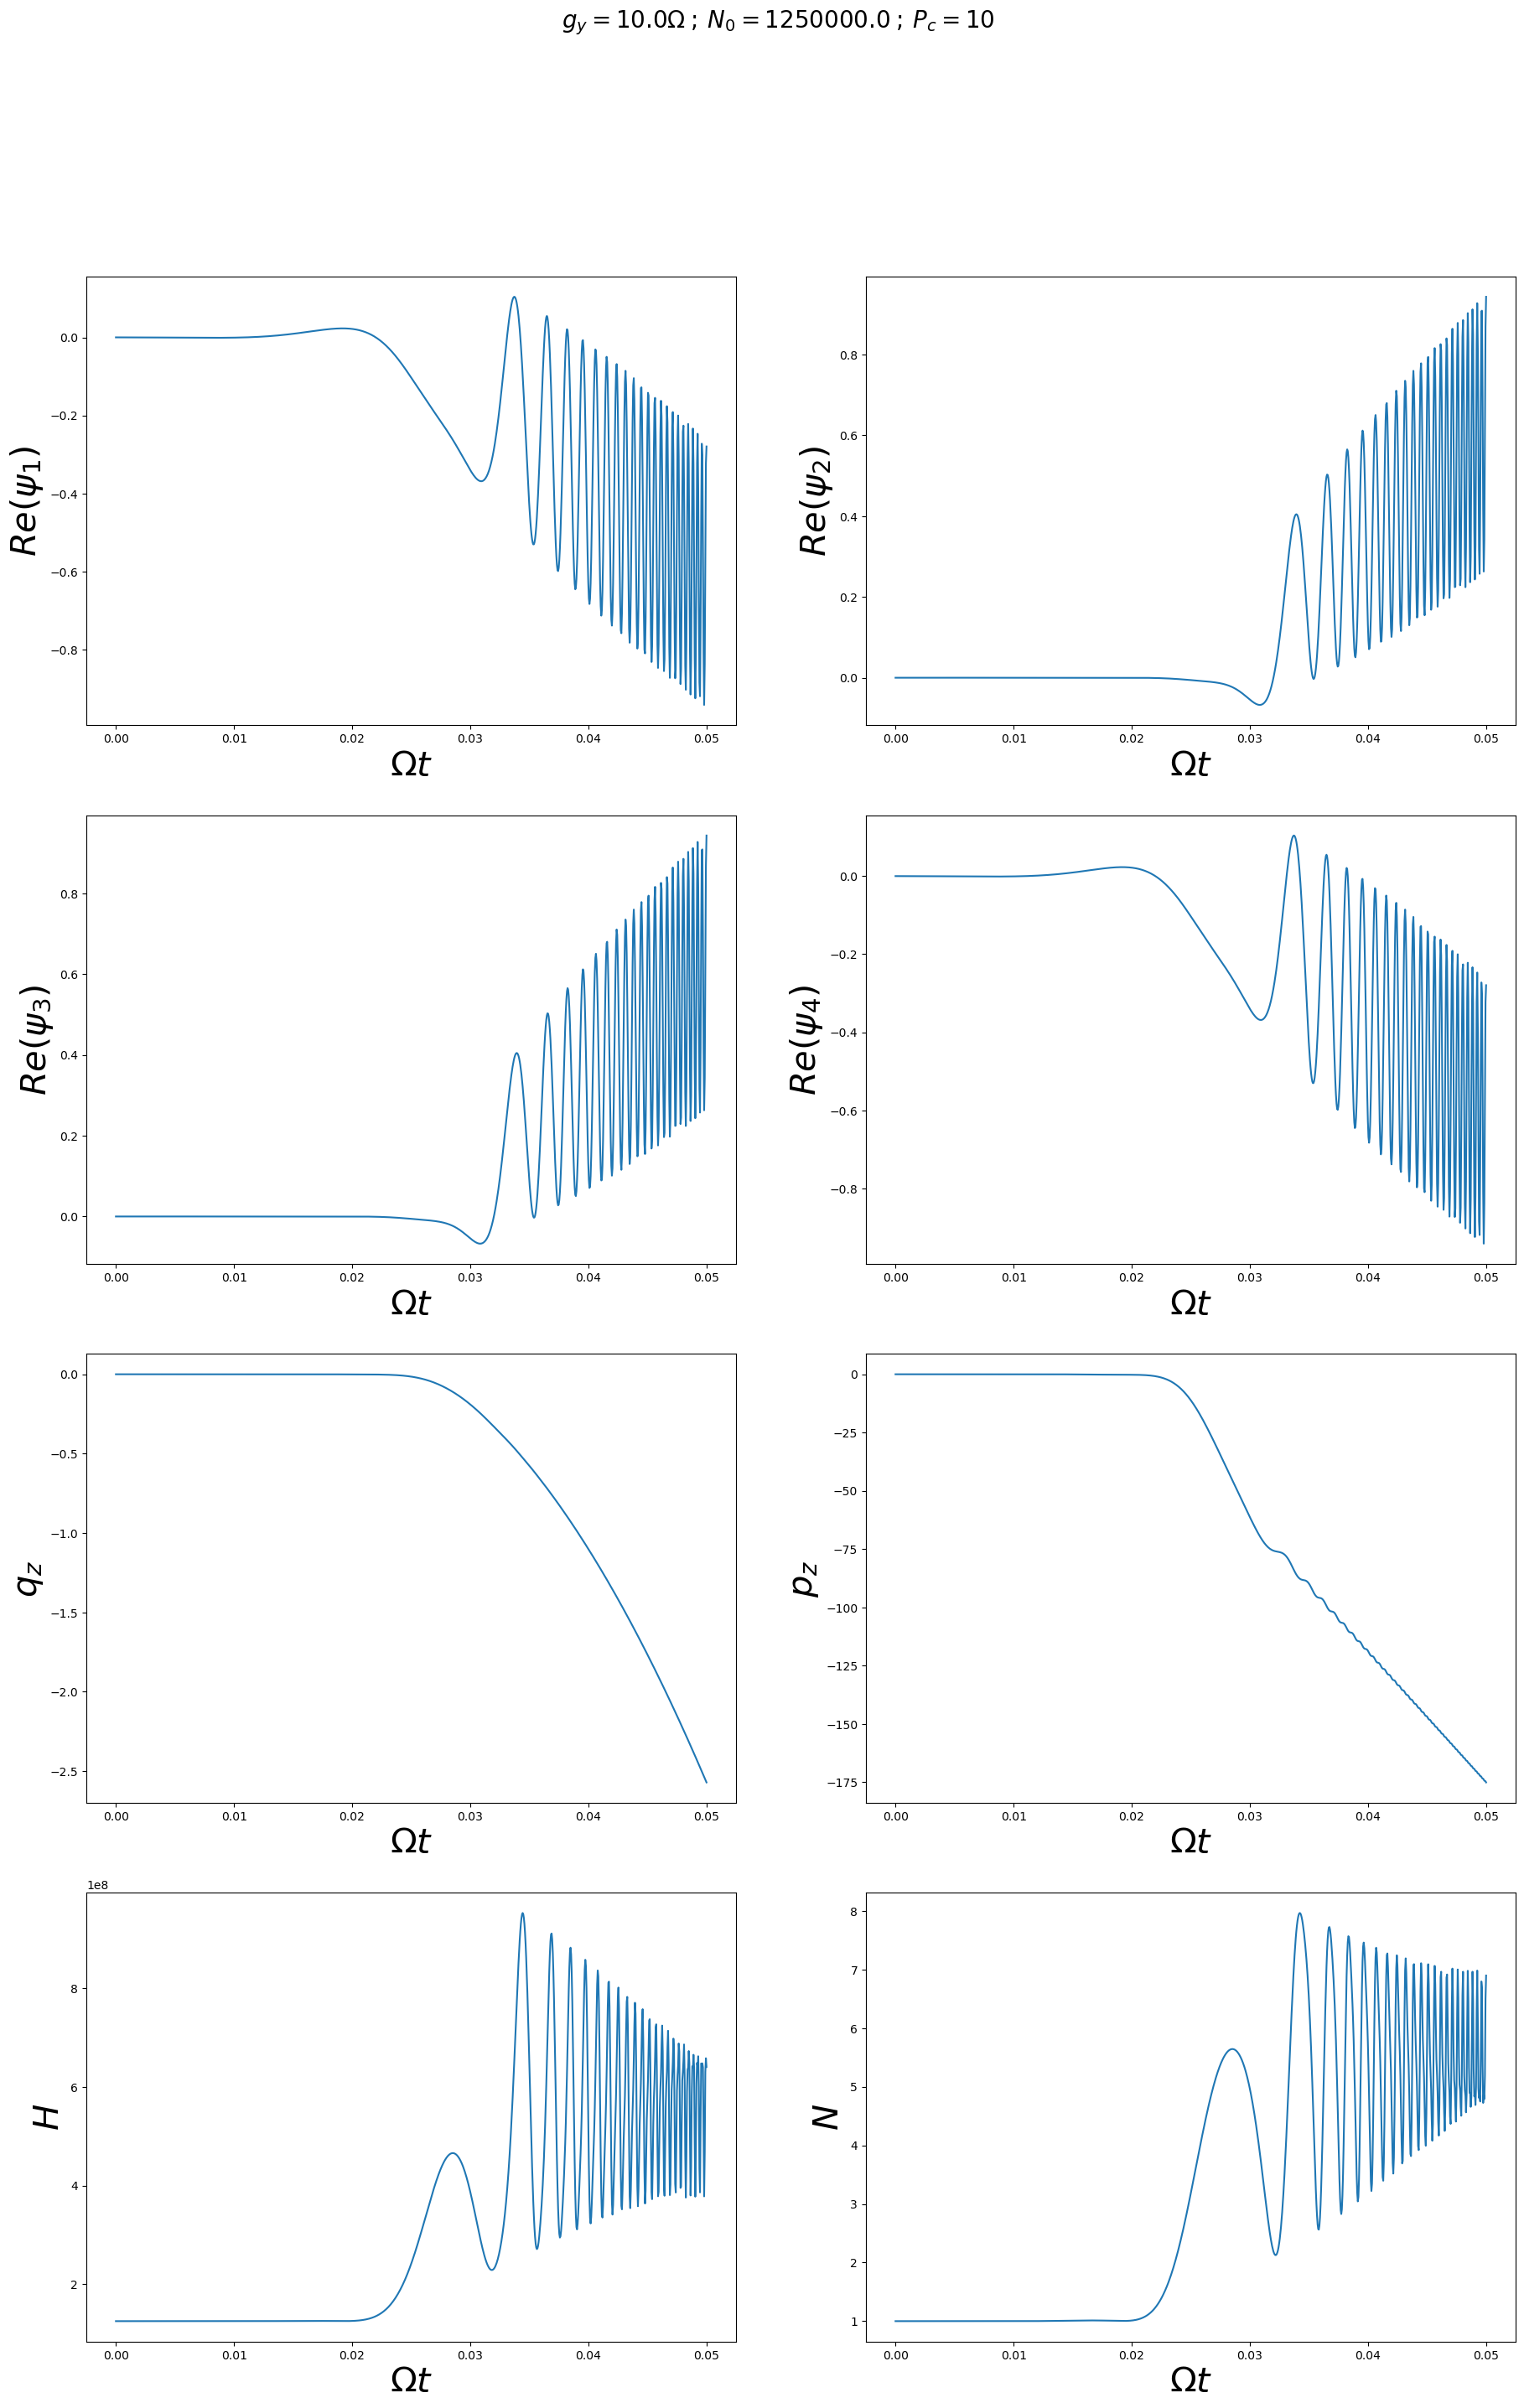

In [79]:
delta=del_omega
P_c=10 ############### CRITICAL parameter
g_y=1e1
N0=(P_c*delta)**3/(8*g**2)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g,N0,P_c)

label_list=["$Re(\psi_1)$","$Re(\psi_2)$","$Re(\psi_3)$","$Re(\psi_4)$","$q_z$","$p_z$","$H$","$N$"]
tf=5e-2
N_step=1000
# N0=1
q0=1e-1
D=((1-delta**2)**2-8*g**2*N0*delta)**0.5
lam=((delta**2+(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
nu=((delta**2-(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
delta_0=(8*g**2*N0)**(1/3)
z0=(delta*g/(2*D))*np.array([1,1,-1,-1,0,0,0,0])*q0+0j

lp=(1-delta**2+D)/(2*delta*g)
lm=(1-delta**2-D)/(2*delta*g)

U=np.array([
            [lp,lp,lm,lm],
            [1j*lp*lam,-1j*lp*lam,1j*lm*nu,-1j*lm*nu],
            [1j*lam/delta,-1j*lam/delta,1j*nu/delta,-1j*nu/delta],
            [1,1,1,1]
    ])
# print(np.linalg.det(U),lam,nu)
U_inv=np.linalg.inv(U)
# print(U_inv)


param_list=[lam,nu,D,delta,g_y,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=eig_evol3(z0,tf,param_list,N_step)

fig, axs = plt.subplots(4, 2,figsize=(22,32))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
fig.suptitle(title, fontsize=20)
for i in range(8):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

/var/folders/98/5wcykpls4kd1dcm4775b11cj50qjlt/T/ipykernel_5464/1925238395.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nl=np.array([0,-2*g*N0*(A_m*w[2]-A_p*w[3]),-g_z1*u_z*w[3]-g*w[0]*A_p,-g_z1*u_z*w[2]-g*w[0]*A_m]).reshape(4,1)


(8, 1000)


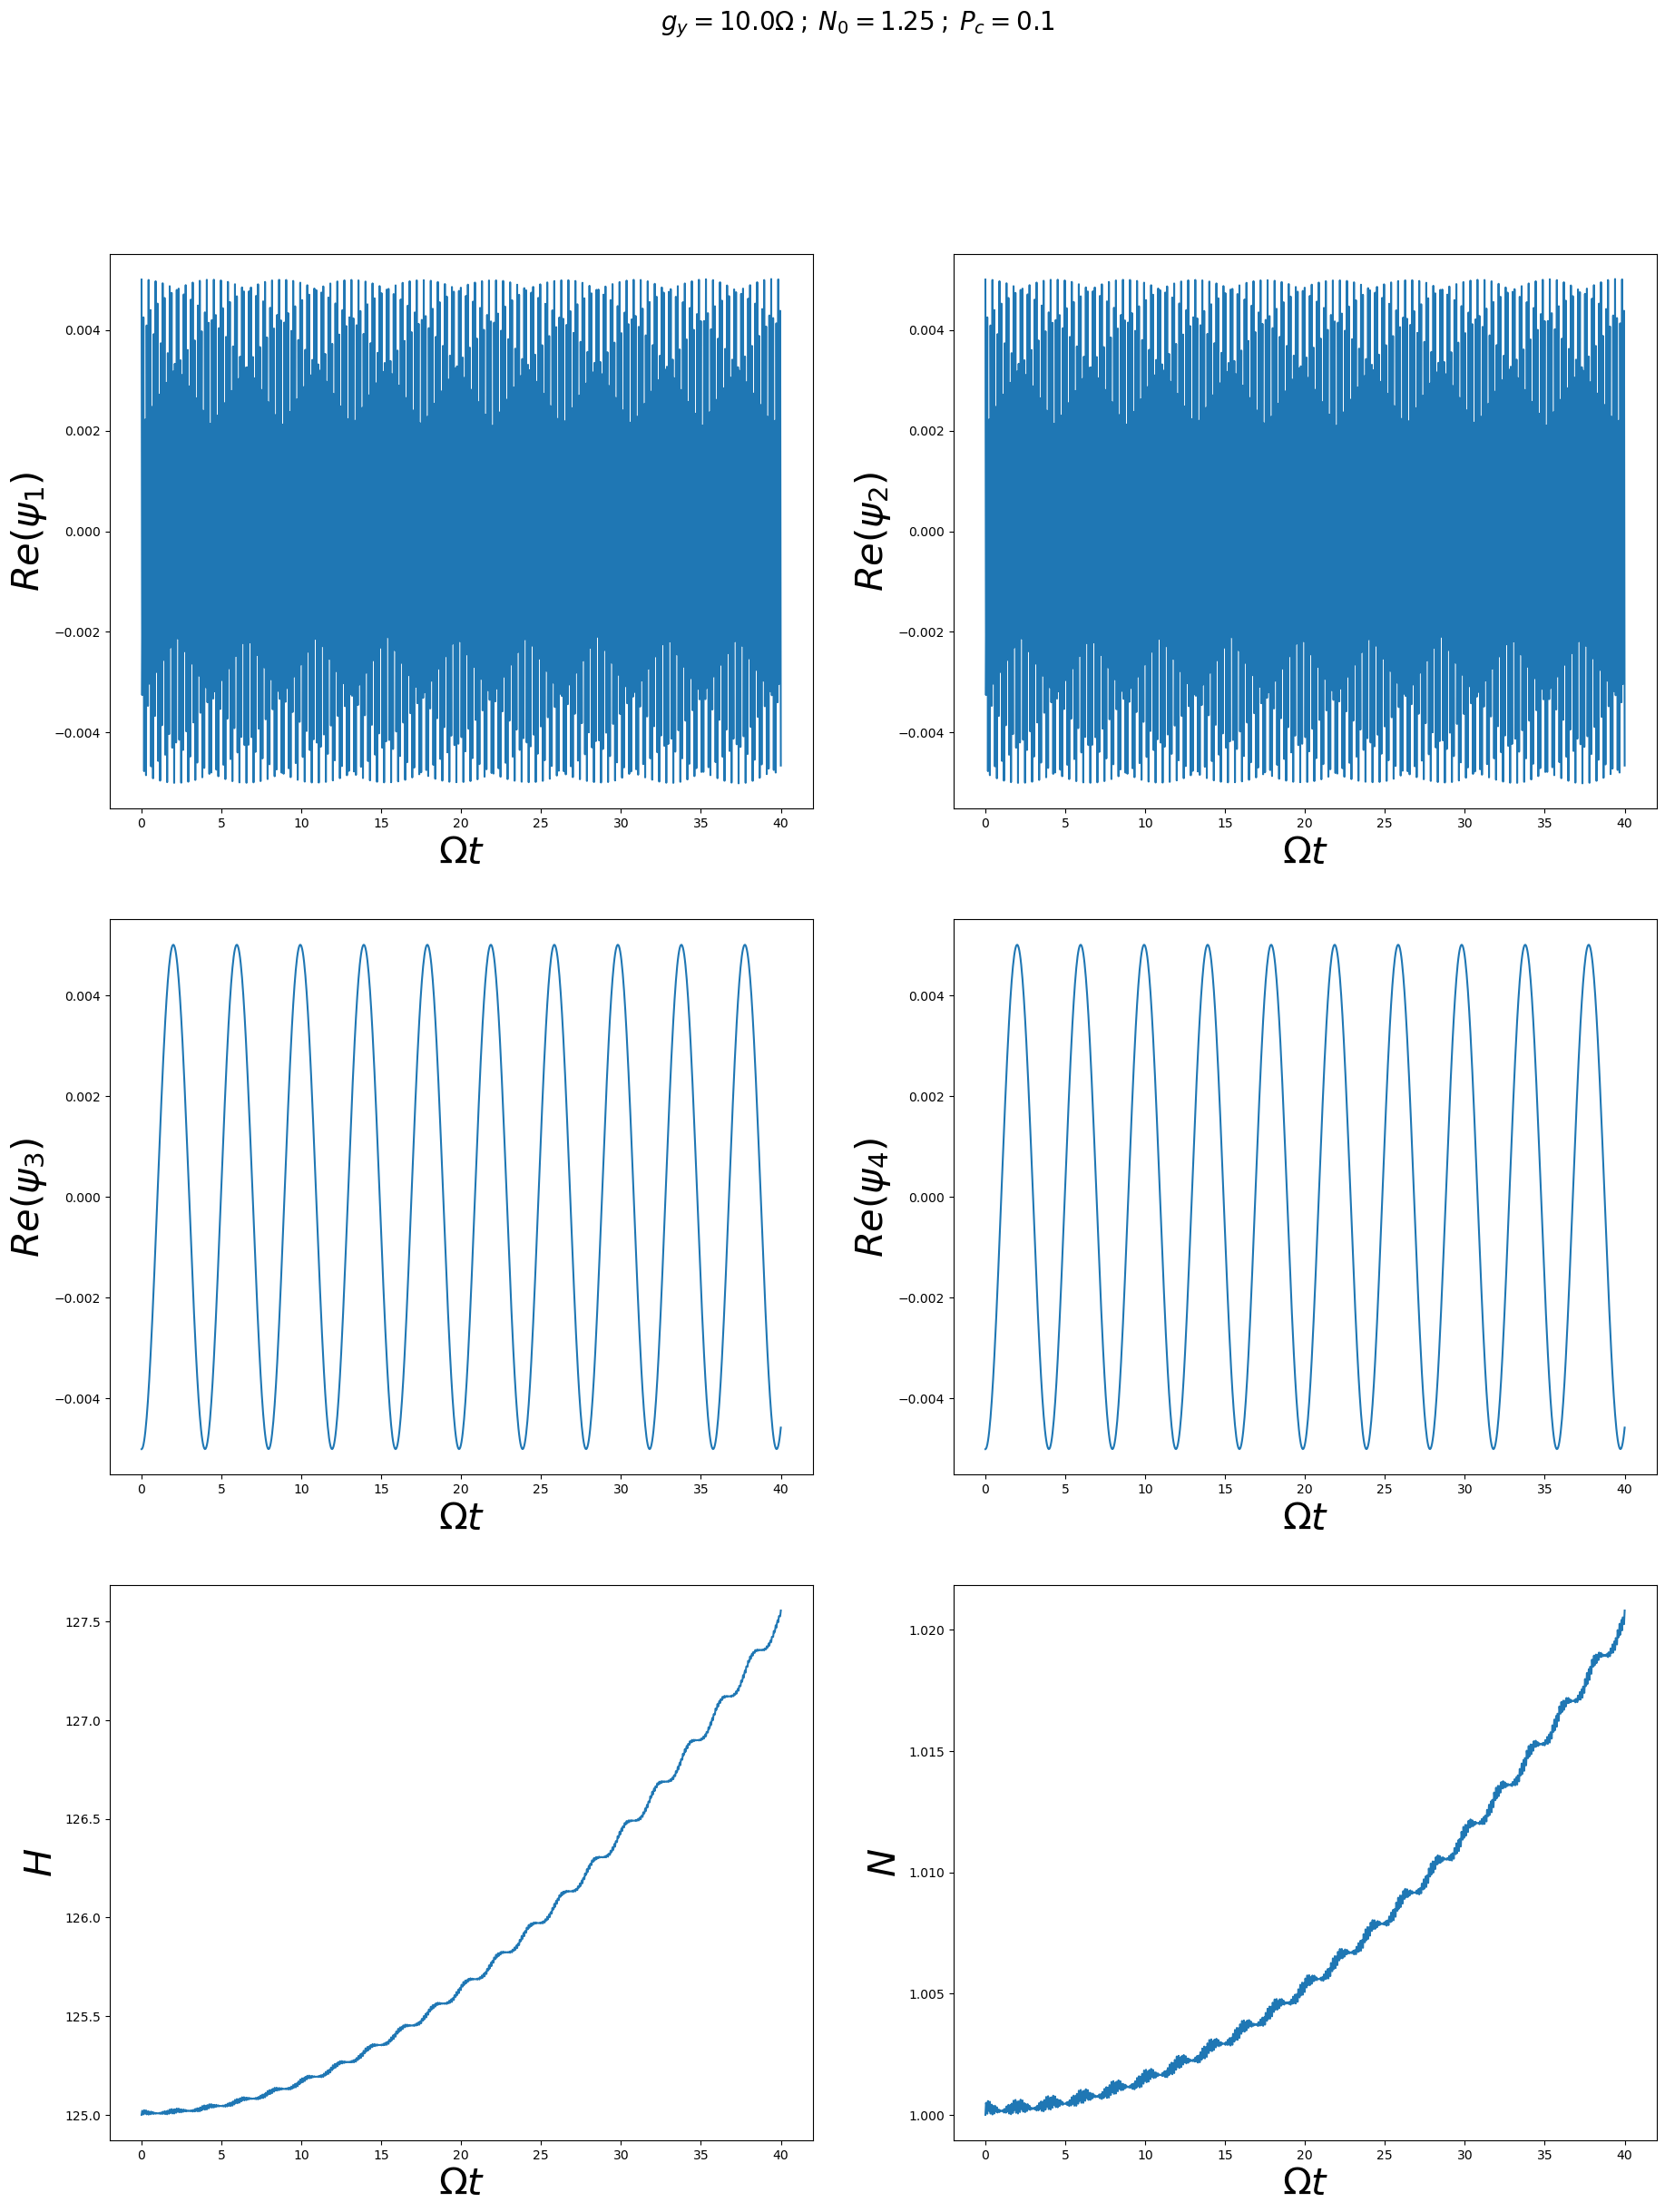

In [53]:
P_c=0.1 ############### CRITICAL parameter
g_y=1e1
N0=(P_c*delta)**3/(8*g**2)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g,N0,P_c)

label_list=["$Re(\psi_1)$","$Re(\psi_2)$","$Re(\psi_3)$","$Re(\psi_4)$","$H$","$N$"]
delta=del_omega
tf=4e1
N_step=1000
q0=1e-1
D=((1-delta**2)**2-8*g**2*N0*delta)**0.5
lam=((delta**2+(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
nu=((delta**2-(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
delta_0=(8*g**2*N0)**(1/3)
z0=(delta*g/(2*D))*np.array([1,1,-1,-1,0,0,0,0])*q0+0j

lp=(1-delta**2+D)/(2*delta*g)
lm=(1-delta**2-D)/(2*delta*g)

U=np.array([
            [lp,lp,lm,lm],
            [1j*lp*lam,-1j*lp*lam,1j*lm*nu,-1j*lm*nu],
            [1j*lam/delta,-1j*lam/delta,1j*nu/delta,-1j*nu/delta],
            [1,1,1,1]
    ])
# print(np.linalg.det(U),lam,nu)
U_inv=np.linalg.inv(U)


param_list=[lam,nu,D,delta,g_y,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=eig_evol3(z0,tf,param_list,N_step)

fig, axs = plt.subplots(3, 2,figsize=(22,27))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
fig.suptitle(title, fontsize=20)
for i in range(6):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

In [64]:
def eig_eq4(t,z,g_z1,g_y,del_omega,N0):
    q_z,p_z,q_y,p_y,A0_p,A0_m,A1_p,A1_m=z
    sigma_m=A1_p*A0_m-A1_m*A0_p
    q_y_dot=p_y
    p_y_dot=-q_y+2*g_y*N0*(A1_m-sigma_m)
    
    q_z_dot=p_z
    p_z_dot=-q_z-g_z1*N0*(A1_p**2+A1_m**2)

    A1_p_dot=-(del_omega+g_z1*q_z)*A1_m-g_y*q_y*(1+A0_p)
#     A1_p_dot=0.1
    A1_m_dot=(del_omega-g_z1*q_z)*A1_p-g_y*q_y*A0_m
    
    A0_p_dot=g_y*q_y*A1_p/2
    A0_m_dot=g_y*q_y*A1_m/2
    
    x_list=[q_z_dot,p_z_dot,q_y_dot,p_y_dot,A0_p_dot,A0_m_dot,A1_p_dot,A1_m_dot]
    return x_list

    
def eig_evol4(z0,tf,param_list,N_step=300):
    def energy(yy):
        q_y=yy[0]
        p_y=yy[1]
        A1_p=yy[2]
        A1_m=yy[3]
        A0_p=yy[4]
        A0_m=yy[5]
        q_z=yy[6]
        p_z=yy[7]
        E=N0*(1+2*A0_p+A0_p**2+A0_m**2)*(del_omega+(g_z0-g_z1)*q_z)+q_z*g_z1*N0
        +(q_y**2+p_y**2+q_z**2+p_z**2)+q_y*g_y*N0*(A1_m+A1_m*A0_p-A1_p*A0_m)
        return E

    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(eig_eq4, [0,tf],z0,args=param_list,dense_output=True,rtol = 1e-8, atol = 1e-8, t_eval=t)
    zz=xx.sol(t)
    sol=[]
    for i in range(8):
        sol.append(np.real(zz[i]))
    E=energy(zz)
    Num=(1+2*zz[4]+zz[4]**2+zz[5]**2)+(zz[2]**2+zz[3]**2)
    sol.extend((E,Num))
    return sol,t



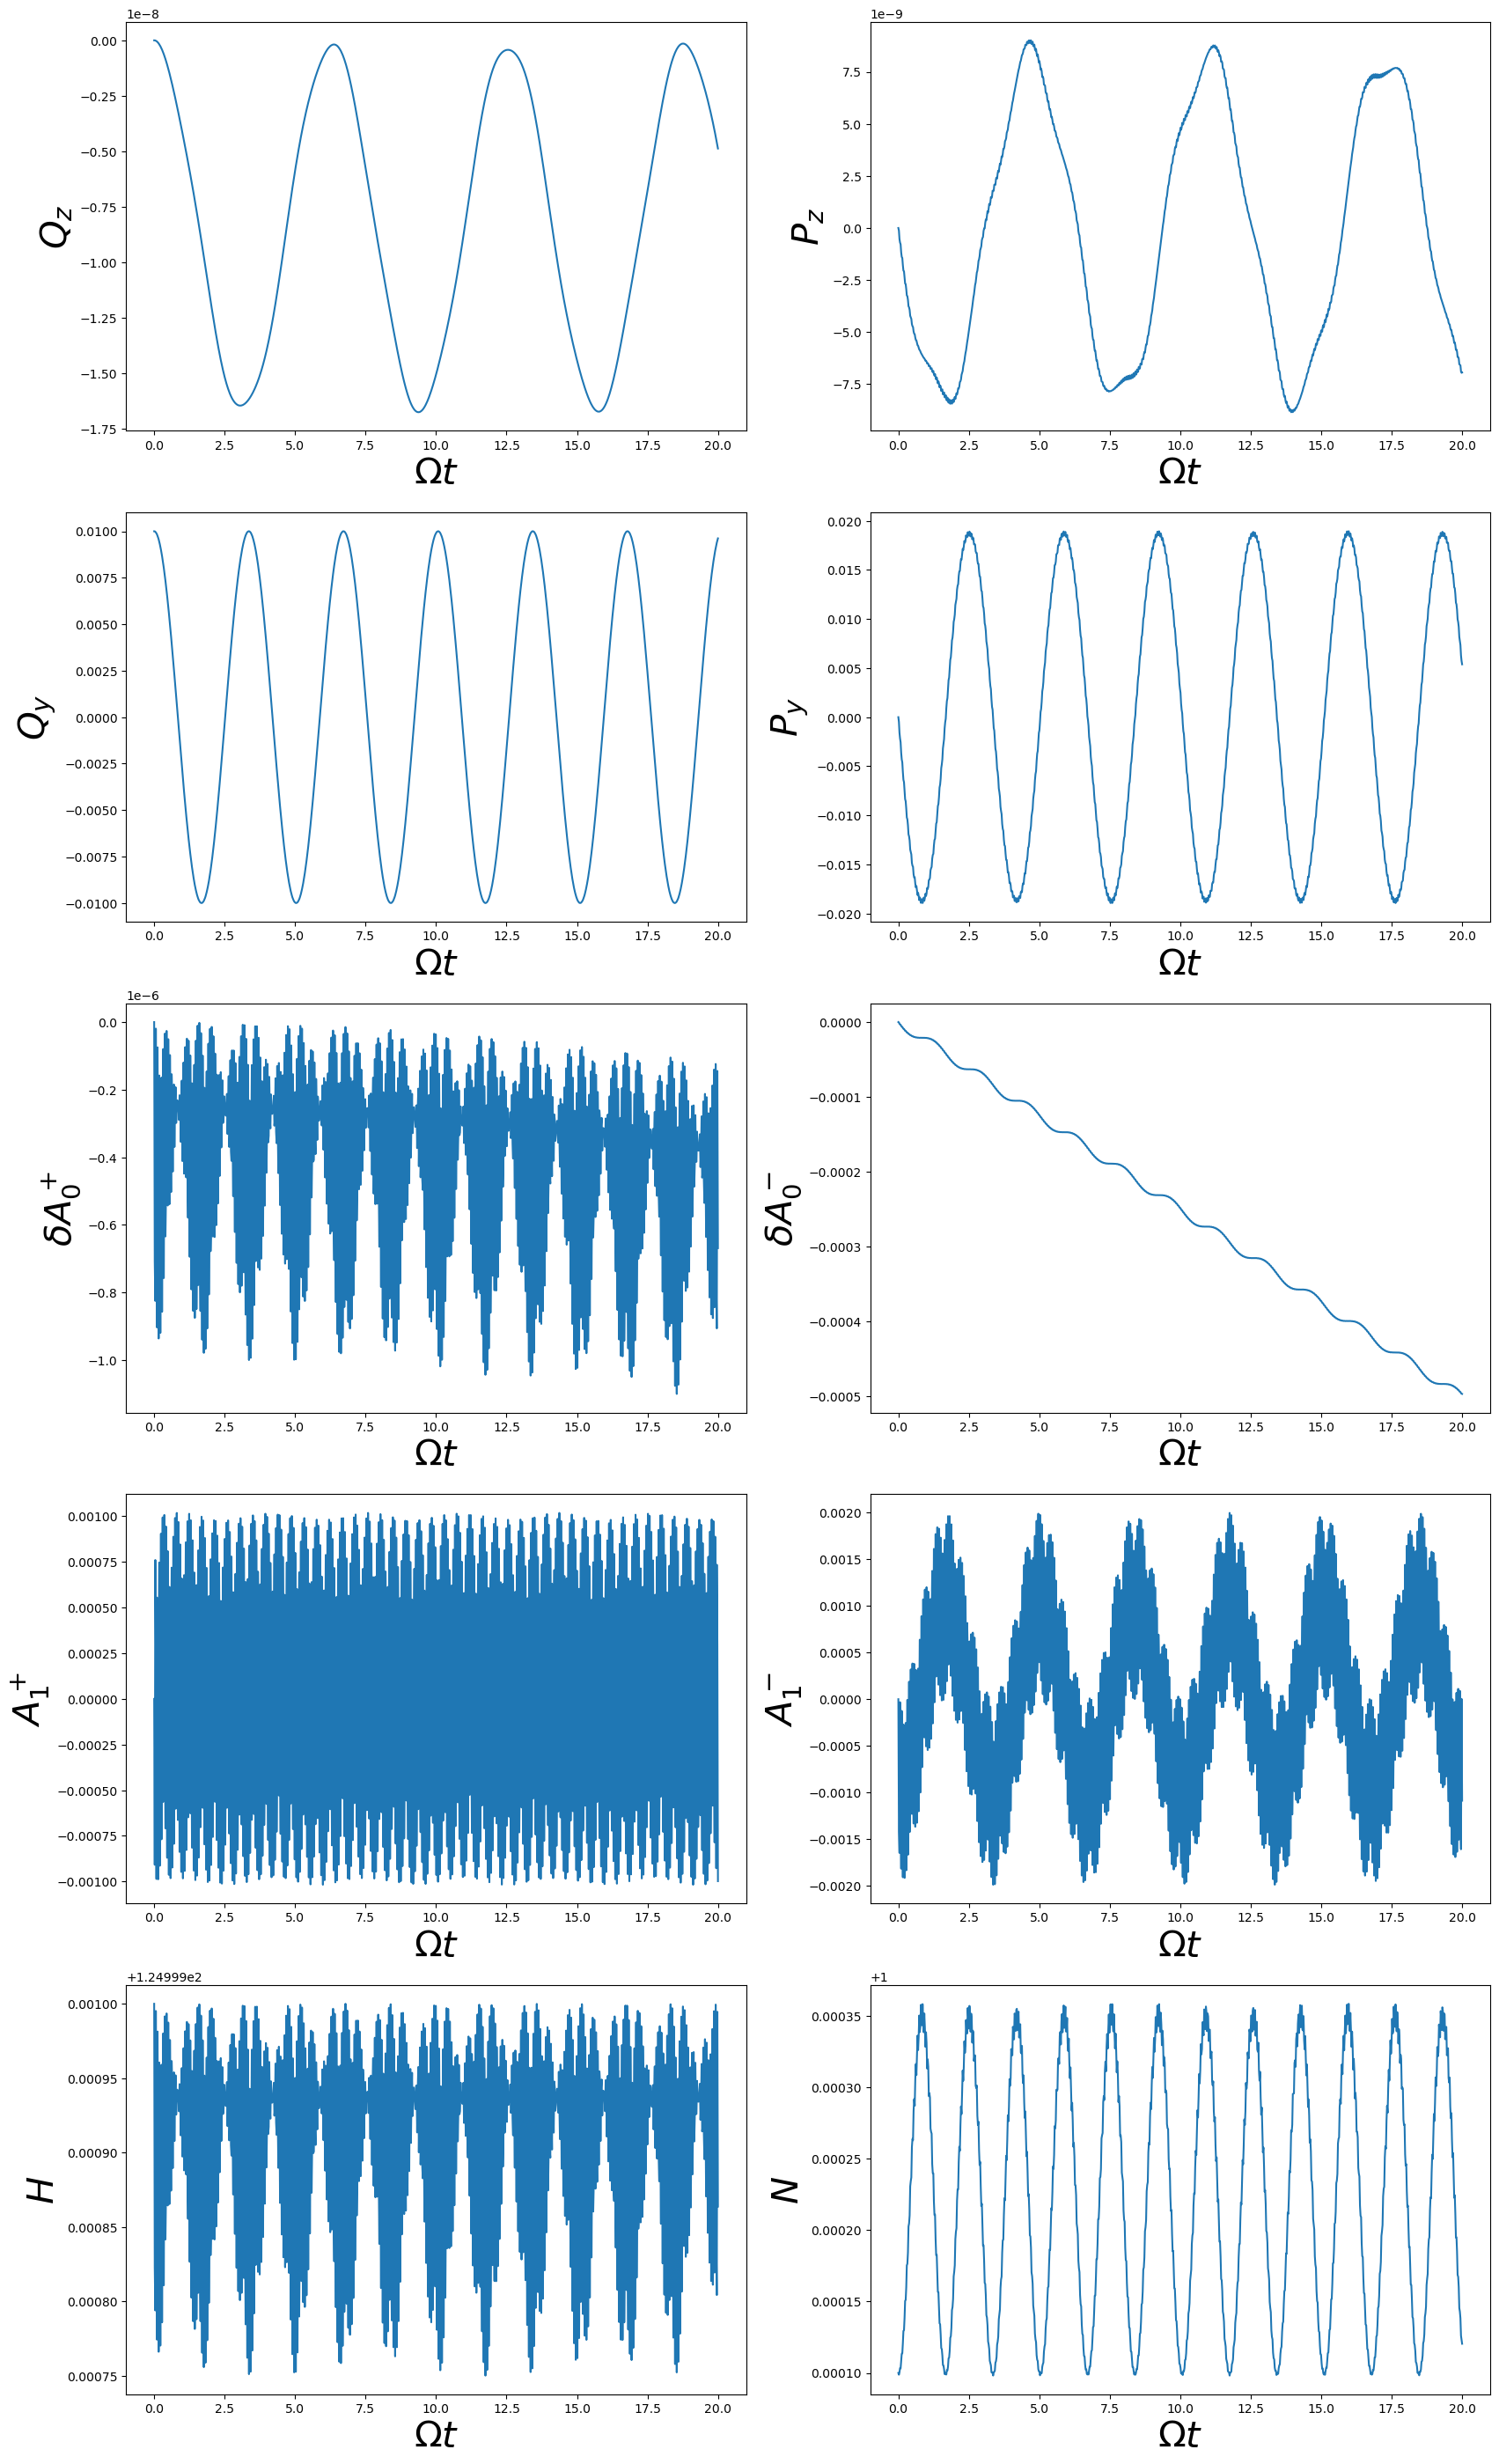

In [76]:
P_c=0.1 ############### CRITICAL parameter
g_y=1e1
N0=(P_c*delta)**3/(8*g_y**2)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P_c)

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$","$H$","$N$"]

tf=2e1
N_step=1000
fig, axs = plt.subplots(5, 2,figsize=(20,35))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
# N0_list=np.linspace(8,9,1)
N0_list=[N0]
qy_0=1e-2
z_0=np.array([0,0,qy_0,0,0,0,0,0])
for N0 in (N0_list):
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=eig_evol4(z_0,tf,param_list,N_step)
    for i in range(10):
        axs[i//2,i%2].plot(t,zz[i])
for i in range(10):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
#     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

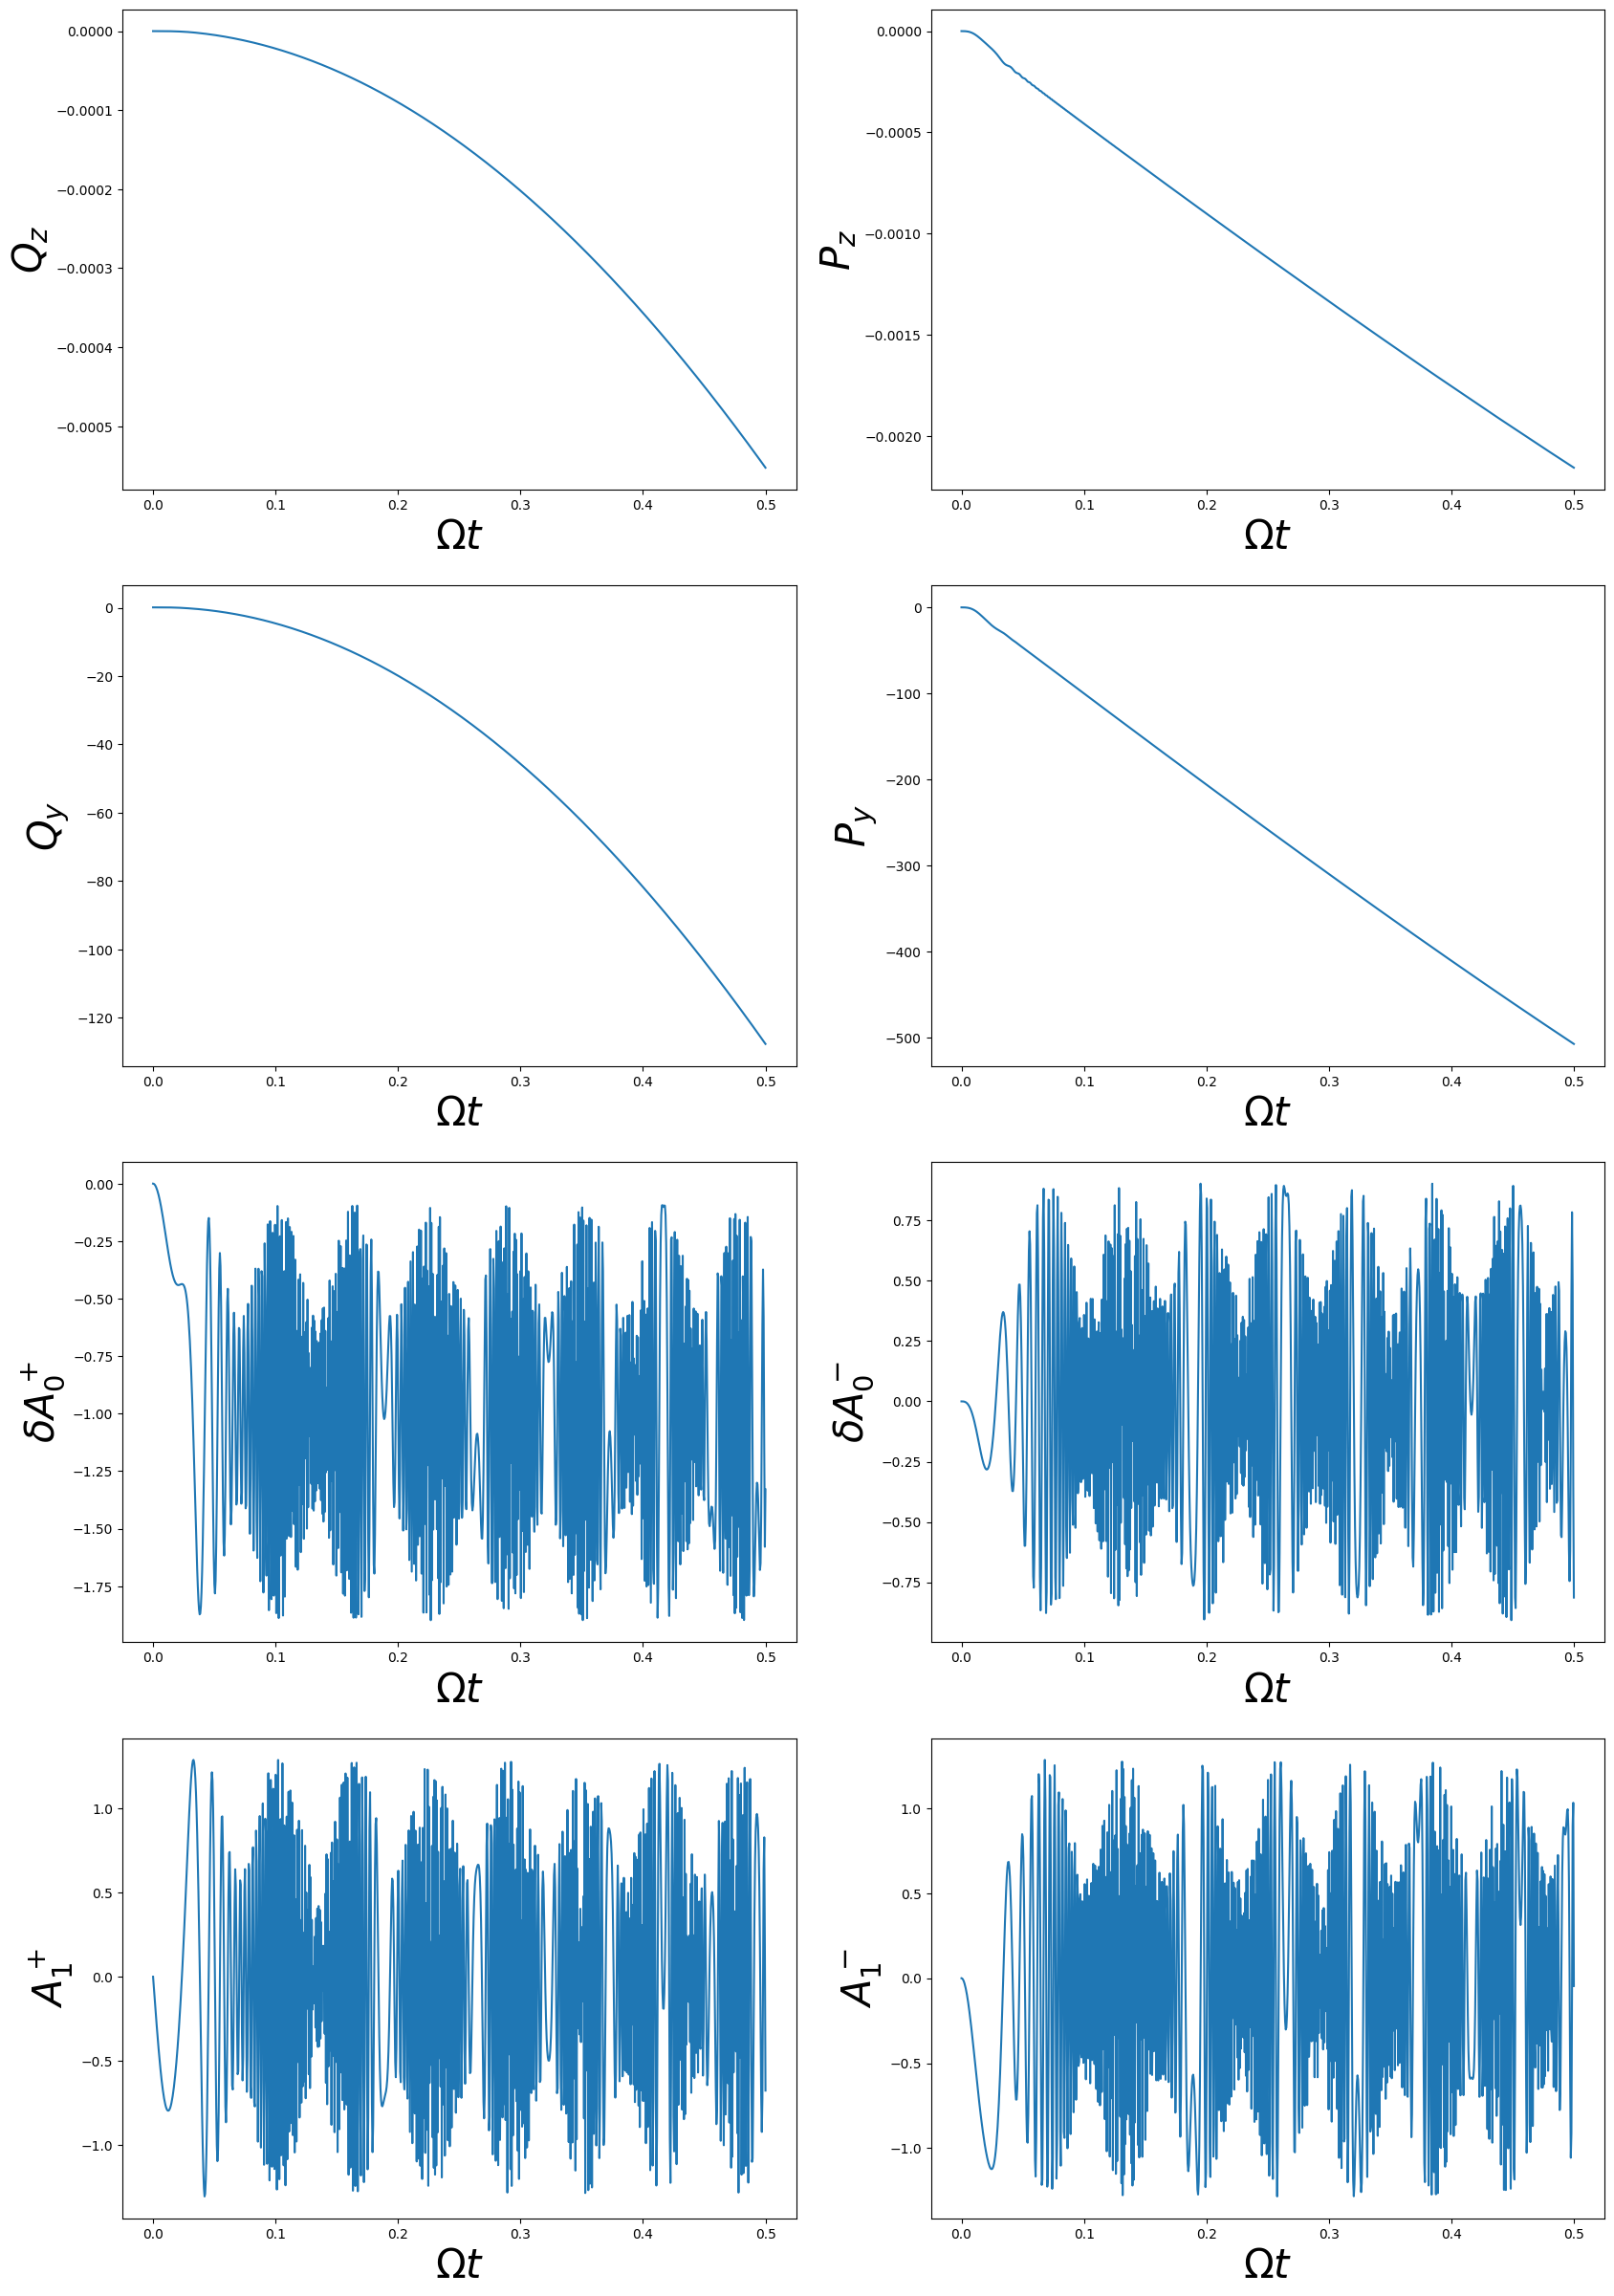

In [55]:
P_c=10 ############### CRITICAL parameter
g_y=1e1
N0=(P_c*delta)**3/(8*g_y**2)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g_y,N0,P_c)

label_list=["$Q_z$","$P_z$","$Q_y$","$P_y$","$\delta A_0^+$","$\delta A_0^-$","$A_1^+$","$A_1^-$"]

tf=5e-1
N_step=1000
g_y=1e3
fig, axs = plt.subplots(4, 2,figsize=(20,30))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
# N0_list=np.linspace(8,9,1)
N0_list=[1]
qy_0=1e-1
z_0=np.array([0,0,qy_0,0,0,0,0,0])
for N0 in (N0_list):
    param_list=[g_z1,g_y,del_omega,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
    zz,t=eig_evol4(z_0,tf,param_list,N_step)
    for i in range(8):
        axs[i//2,i%2].plot(t,zz[i])
for i in range(8):
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)
#     axs[i//2,i%2].legend(fontsize=12)

plt.show() 

In [32]:
def eig_eq5(t,z,lam,nu,D,delta,g,g_z1,N0):
    phi_1,phi_1_d,phi_2,phi_2_d,A_p,A_m,u_z,p_z=z
    phi=np.array([phi_1,phi_1_d,phi_2,phi_2_d]).reshape(4,1)
    w=U@E@phi
    nl=np.array([0,-2*g*N0*(A_m*w[2]-A_p*w[3]),-g_z1*u_z*w[3]-g*w[0]*A_p,-g_z1*u_z*w[2]-g*w[0]*A_m]).reshape(4,1)
    phi_dot=E_inv@U_inv@nl
    
    u_z_dot=p_z
    p_z_dot=-u_z-g_z1*N0*(w[2]**2+w[3]**2)
    A_p_dot=g*w[0]*w[2]/2
    A_m_dot=g*w[0]*w[3]/2
    
    psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot=phi_dot[:,0]
    x_list=[psi_1_dot,psi_2_dot,psi_3_dot,psi_4_dot,A_p_dot,A_m_dot,u_z_dot,p_z_dot]
    return x_list

def eig_evol5(z0,tf,param_list,N_step=300):
    
    t = np.linspace(0,tf,N_step)
    xx=solve_ivp(eig_eq5, [0,tf],z0,args=param_list,dense_output=True,rtol = 1e-8, atol = 1e-8, t_eval=t)
    zz=xx.sol(t)
    sol=[]
    sol.extend( (np.real(zz[0]),np.real(zz[1]),np.real(zz[2]),np.real(zz[3])) )
    return sol,t

(1774.185793955962+0j) 99.89974894460693 4.47662381762269


C:\Users\jhash\AppData\Local\Temp\ipykernel_4568\1048740538.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nl=np.array([0,-2*g*N0*(A_m*w[2]-A_p*w[3]),-g_z1*u_z*w[3]-g*w[0]*A_p,-g_z1*u_z*w[2]-g*w[0]*A_m]).reshape(4,1)


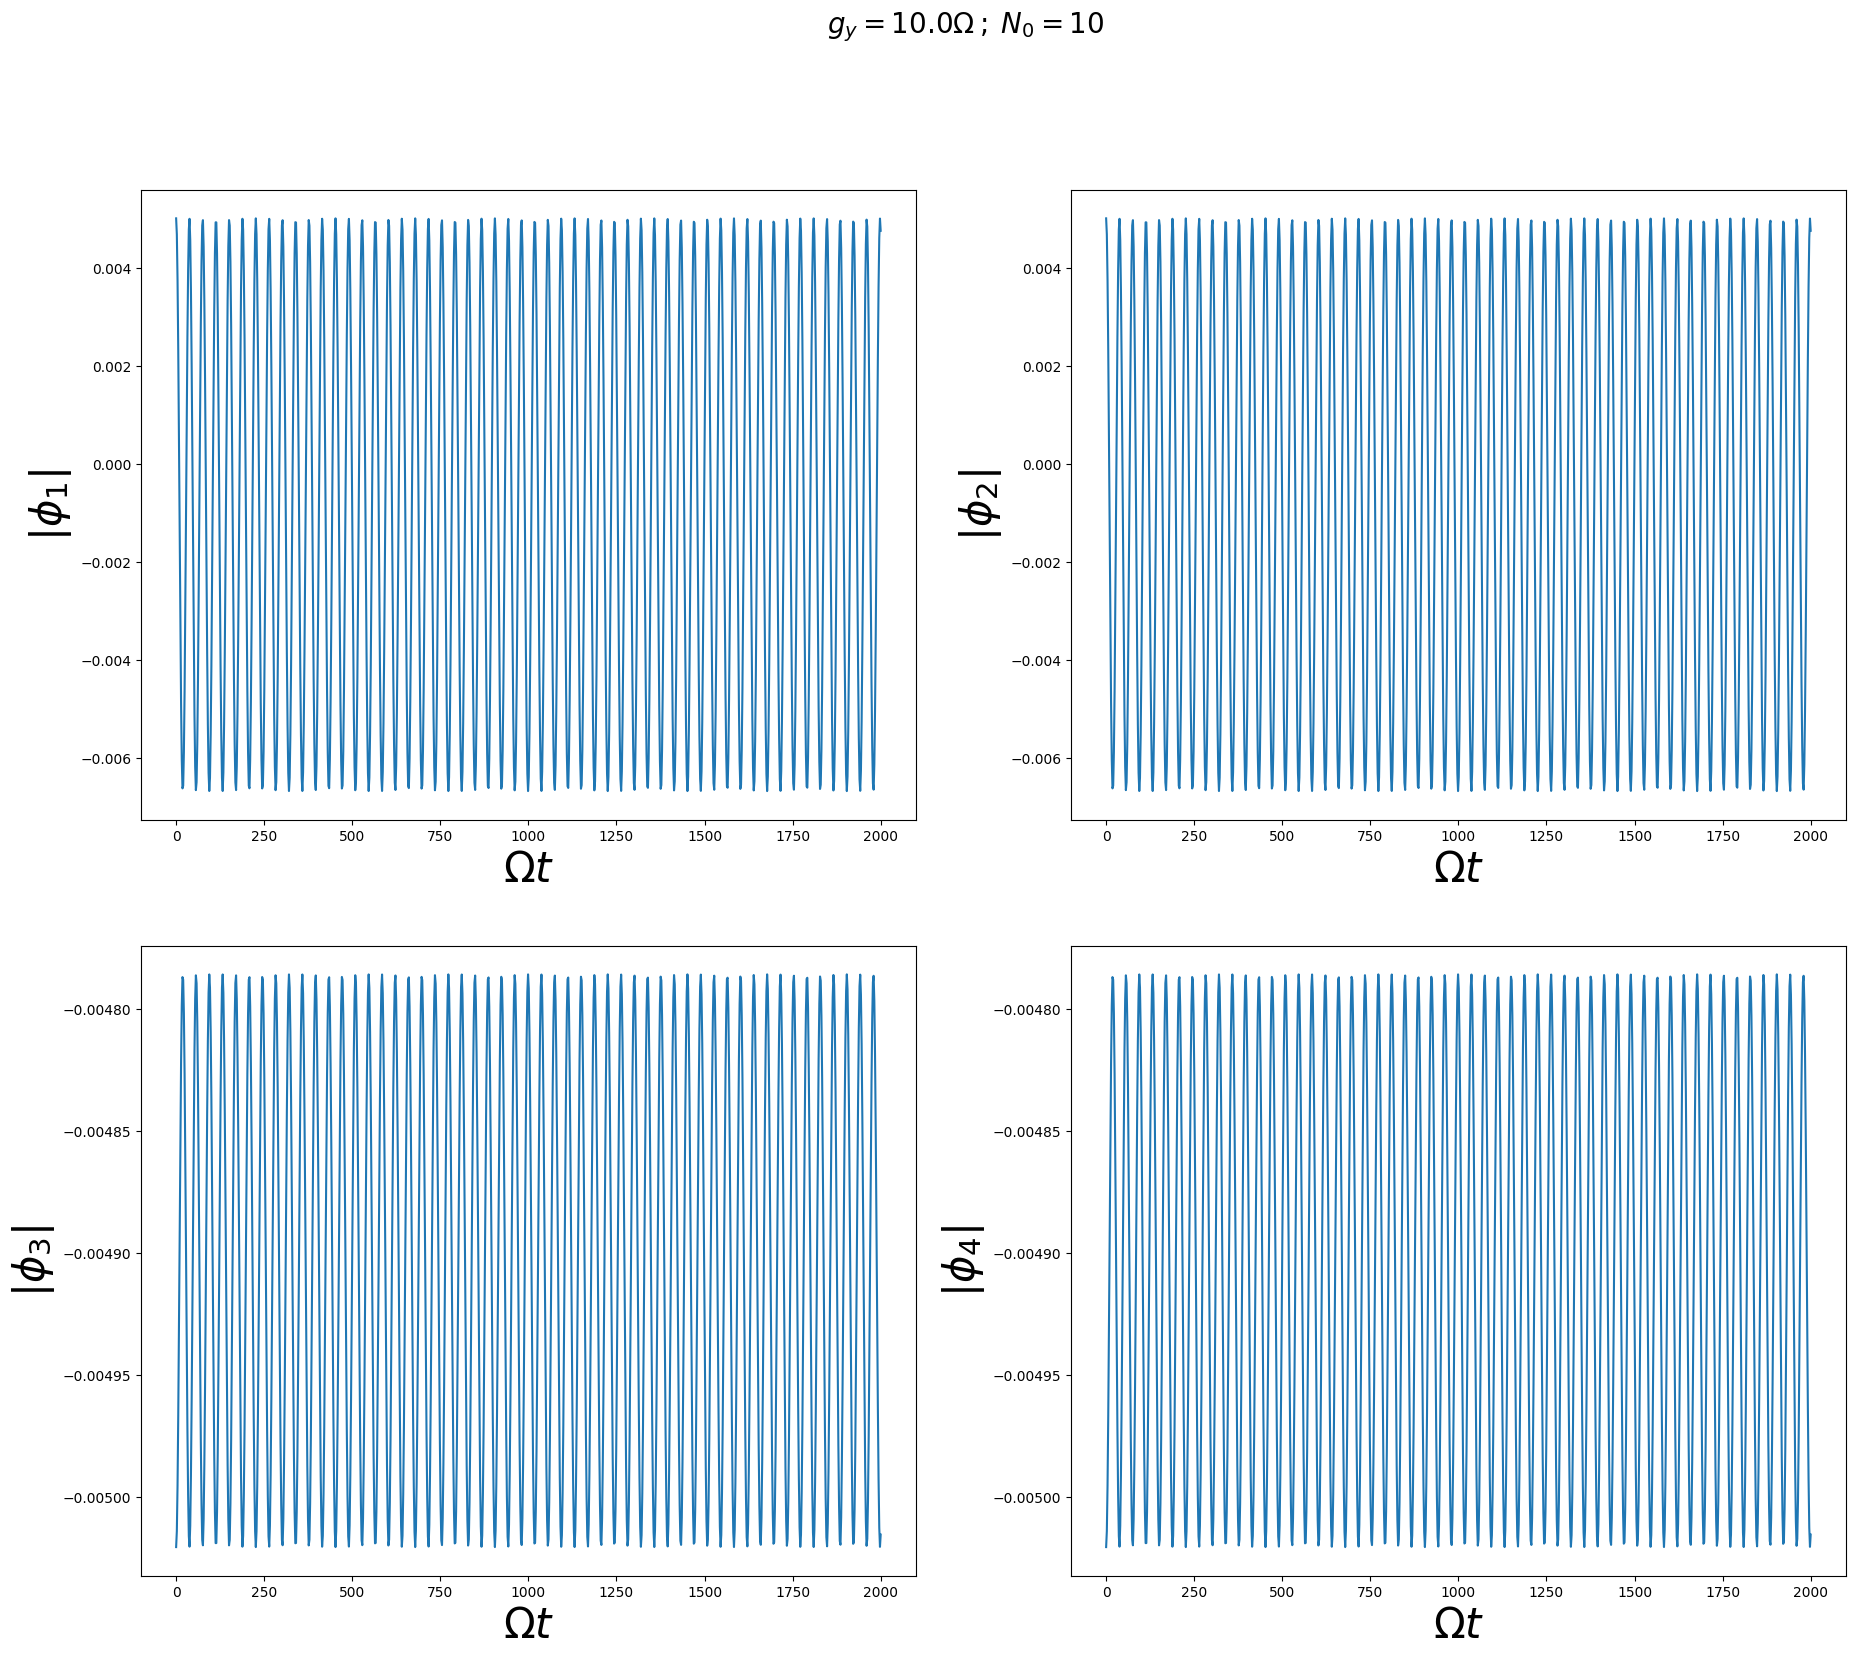

In [33]:
P_c=0.1 ############### CRITICAL parameter
g=1e1
N0=(P_c*delta)**3/(8*g_y**2)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g,N0,P_c)


label_list=["$|\phi_1|$","$|\phi_2|$","$|\phi_3|$","$|\phi_4|$"]
delta=del_omega
tf=2e3
N_step=1000
# N0=10
q0=1e-1
D=((1-delta**2)**2-8*g**2*N0*delta)**0.5
lam=((delta**2+(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
nu=((delta**2-(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
delta_0=(8*g**2*N0)**(1/3)
z0=(delta*g/(2*D))*np.array([1,1,-1,-1,0,0,0,0])*q0+0j

lp=(1-delta**2+D)/(2*delta*g)
lm=(1-delta**2-D)/(2*delta*g)

U=np.array([
            [lp,lp,lm,lm],
            [1j*lp*lam,-1j*lp*lam,1j*lm*nu,-1j*lm*nu],
            [1j*lam/delta,-1j*lam/delta,1j*nu/delta,-1j*nu/delta],
            [1,1,1,1]
    ])
E=np.diag(np.exp(1j*np.array([-lam,lam,-nu,nu])))

print(np.linalg.det(U),lam,nu)
U_inv=np.linalg.inv(U)
E_inv=np.diag(np.exp(-1j*np.array([-lam,lam,-nu,nu])))


param_list=[lam,nu,D,delta,g,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=eig_evol5(z0,tf,param_list,N_step)

fig, axs = plt.subplots(2, 2,figsize=(22,18))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
fig.suptitle('$g_y={0}\Omega  \: ; \: N_0={1} $'.format(g,N0), fontsize=20)
for i in range(4):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

In [41]:
P_c=10 ############### CRITICAL parameter
g=1e1
N0=(P_c*delta)**3/(8*g_y**2)
title='$g_y={0}\Omega  \: ; \: N_0={1} \: ; \: P_c={2}$'.format(g,N0,P_c)

label_list=["$|\phi_1|$","$|\phi_2|$","$|\phi_3|$","$|\phi_4|$"]
delta=del_omega
tf=1e-5
N_step=1000
# N0=1
q0=1e-1
D=((1-delta**2)**2-8*g**2*N0*delta)**0.5
lam=((delta**2+(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
nu=((delta**2-(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
delta_0=(8*g**2*N0)**(1/3)
z0=(delta*g/(2*D))*np.array([1,1,-1,-1,0,0,0,0])*q0+0j

lp=(1-delta**2+D)/(2*delta*g)
lm=(1-delta**2-D)/(2*delta*g)

U=np.array([
            [lp,lp,lm,lm],
            [1j*lp*lam,-1j*lp*lam,1j*lm*nu,-1j*lm*nu],
            [1j*lam/delta,-1j*lam/delta,1j*nu/delta,-1j*nu/delta],
            [1,1,1,1]
    ])
E=np.diag(np.exp(1j*np.array([-lam,lam,-nu,nu])))

print(np.linalg.det(U),lam,nu)
U_inv=np.linalg.inv(U)
E_inv=np.diag(np.exp(-1j*np.array([-lam,lam,-nu,nu])))


param_list=[lam,nu,D,delta,g,g_z1,N0]   ##g_z0,g_z1,g_y,ohm, omega_0, omega_1, del_omega, N_eq
zz,t=eig_evol5(z0,tf,param_list,N_step)

fig, axs = plt.subplots(2, 2,figsize=(22,18))
# fig.suptitle('Dynamics with varying '+"$P_c$"+" , with only initial mechanical pumping", fontsize=20)
fig.suptitle('$g_y={0}\Omega  \: ; \: N_0={1} $'.format(g,N0), fontsize=20)
for i in range(4):
    axs[i//2,i%2].plot(t,zz[i])
    axs[i//2,i%2].set_ylabel(label_list[i],fontsize=30)
    axs[i//2,i%2].set_xlabel('$\Omega  t$',fontsize=30)

plt.show()

(-3.9626262603480567+3.621184937269222e-16j) (72.99607609143241+18.122558449241932j) (72.99607609143241-18.122558449241932j)


C:\Users\jhash\AppData\Local\Temp\ipykernel_4568\1048740538.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  nl=np.array([0,-2*g*N0*(A_m*w[2]-A_p*w[3]),-g_z1*u_z*w[3]-g*w[0]*A_p,-g_z1*u_z*w[2]-g*w[0]*A_m]).reshape(4,1)


KeyboardInterrupt: 

In [56]:
label_list=["$|\phi_1|$","$|\phi_2|$","$|\phi_3|$","$|\phi_4|$"]
delta=del_omega
g=4e2
tf=1e-5
N_step=1000
N0=1
q0=1e-1
D=((1-delta**2)**2-8*g**2*N0*delta)**0.5
lam=((delta**2+(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
nu=((delta**2-(delta**4-8*g**2*N0*delta)**0.5)/2)**0.5
delta_0=(8*g**2*N0)**(1/3)
z0=(delta*g/(2*D))*np.array([1,1,-1,-1,0,0,0,0])*q0+0j

lp=(1-delta**2+D)/(2*delta*g)
lm=(1-delta**2-D)/(2*delta*g)

U=np.array([
            [lp,lp,lm,lm],
            [1j*lp*lam,-1j*lp*lam,1j*lm*nu,-1j*lm*nu],
            [1j*lam/delta,-1j*lam/delta,1j*nu/delta,-1j*nu/delta],
            [1,1,1,1]
    ])
E=np.diag(np.exp(1j*np.array([-lam,lam,-nu,nu])))

print(np.linalg.det(U),lam,nu)

(-3.9626262603480567+3.621184937269222e-16j) (72.99607609143241+18.122558449241932j) (72.99607609143241-18.122558449241932j)


In [50]:
U

array([[-0.049995   +0.13228946j, -0.049995   +0.13228946j,
        -0.049995   -0.13228946j, -0.049995   -0.13228946j],
       [-9.5619745 -13.8351493j ,  9.5619745 +13.8351493j ,
         9.5619745 -13.8351493j , -9.5619745 +13.8351493j ],
       [-0.67609672 +0.97831834j,  0.67609672 -0.97831834j,
         0.67609672 +0.97831834j, -0.67609672 -0.97831834j],
       [ 1.         +0.j        ,  1.         +0.j        ,
         1.         +0.j        ,  1.         +0.j        ]])